# Settings

In [1]:
import os, time
import networkx as nx

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import chain
from collections import defaultdict
from gensim.models import Word2Vec
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

In [2]:
import gensim
print(
    gensim.__version__
)

3.6.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!rm -f data
!ln -s '/content/drive/MyDrive/Comp 4332/Project 2/data' data

In [47]:
import torch
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

seed = 0
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

In [6]:
!nvidia-smi

Fri Apr 29 12:50:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    28W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Pipeline

### Data Loader

We need to load networks into memory. Usually networks are organized as pairs of nodes. And sometimes different edges have different weights. Hence, we use networkx.DiGraph to store such structure information and attributes.

In [7]:
def construct_uid_index(file_train_csv='data/train.csv'):
    '''
        build two dictionaries to 
        convert uid (--UOvCH5qEgdNQ8lzR8QYQ, ...) to index (1,2,3,...)
    '''
    df = pd.read_csv(file_train_csv)

    list_uid = []
    for idx, row in df.iterrows():
        user_id, friends = row["user_id"], eval(row["friends"])
        list_uid.append(user_id)
        list_uid.extend(friends)

    sorted_list_unique_uid = ['']+sorted(set(list_uid))

    uid2index = {}
    index2uid = {}
    uid2ind = {}
    ind2uid = {}
    for i, uid in enumerate(sorted_list_unique_uid):
        uid2index.update({uid: str(i)})
        index2uid.update({str(i): uid})
        uid2ind.update({uid: i})
        ind2uid.update({i: uid})

    return index2uid, uid2index, uid2ind, ind2uid

In [8]:
def load_data(file_name, uid2index):
    """
    read edges from an edge file
    """
    edges = list()
    df = pd.read_csv(file_name)
    for idx, row in df.iterrows():
        user_id, friends = row["user_id"], eval(row["friends"])
        for friend in friends:
            # add each friend relation as an edge
            edges.append(
                (uid2index.get(user_id, '0'), uid2index.get(friend, '0'))
            )
    edges = sorted(edges)
    
    return edges

def load_test_data(file_name, uid2index):
    """
    read edges from an edge file
    """
    edges = list()
    scores = list()
    df = pd.read_csv(file_name)
    for idx, row in df.iterrows():
        edges.append(
            (uid2index.get(row["src"], '0'), uid2index.get(row["dst"], '0'))
        )
    # edges = sorted(edges)
    
    return edges

def generate_false_edges(true_edges, num_false_edges=5):
    """
    generate false edges given true edges
    """
    nodes = list(set(chain.from_iterable(true_edges)))
    N = len(nodes)
    true_edges = set(true_edges)
    print(N, len(true_edges))
    false_edges = set()
    
    while len(false_edges) < num_false_edges:
        # randomly sample two different nodes and check whether the pair exisit or not
        src, dst = nodes[int(np.random.rand() * N)], nodes[int(np.random.rand() * N)]
        if src != dst and (src, dst) not in true_edges and (src, dst) not in false_edges:
            false_edges.add((src, dst))
    false_edges = sorted(false_edges)
    
    return false_edges

def construct_graph_from_edges(edges):
    """
    generate a directed graph object given true edges
    DiGraph documentation: https://networkx.github.io/documentation/stable/reference/classes/digraph.html
    """
    # convert a list of edges {(u, v)} to a list of edges with weights {(u, v, w)}
    edge_weight = defaultdict(float)
    for e in edges:
        edge_weight[e] += 1.0
    weighed_edge_list = list()
    for e in sorted(edge_weight.keys()):
        weighed_edge_list.append((e[0], e[1], edge_weight[e]))
        
    graph = nx.DiGraph()
    graph.add_weighted_edges_from(weighed_edge_list)
    
    print("number of nodes:", graph.number_of_nodes())
    print("number of edges:", graph.number_of_edges())
    
    return graph

### Random Walk Generator

Random walk generators or random walkers yield random walks that contain both local and higher-order neighborhood information. However, naive non-uniform sampling is very slow, which requires O(n) time complexity. Here alias sampling can reduce the time complexity to O(1) with O(n) space. If you are interested, please see the following blog.

In [9]:
def alias_setup(probs):
    """
    compute utility lists for non-uniform sampling from discrete distributions.
    details: https://lips.cs.princeton.edu/the-alias-method-efficient-sampling-with-many-discrete-outcomes/
    """
    K = len(probs)
    q = np.zeros(K)
    J = np.zeros(K, dtype=np.int32)

    smaller = list()
    larger = list()
    for kk, prob in enumerate(probs):
        q[kk] = K * prob
        if q[kk] < 1.0:
            smaller.append(kk)
        else:
            larger.append(kk)

    while len(smaller) > 0 and len(larger) > 0:
        small = smaller.pop()
        large = larger.pop()

        J[small] = large
        q[large] = q[large] + q[small] - 1.0
        if q[large] < 1.0:
            smaller.append(large)
        else:
            larger.append(large)

    return J, q

def get_alias_node(graph, node):
    """
    get the alias node setup lists for a given node.
    """
    # get the unnormalized probabilities with the first-order information
    unnormalized_probs = list()
    for nbr in graph.neighbors(node):
        unnormalized_probs.append(graph[node][nbr]["weight"])
    unnormalized_probs = np.array(unnormalized_probs)
    if len(unnormalized_probs) > 0:
        normalized_probs = unnormalized_probs / unnormalized_probs.sum()
    else:
        normalized_probs = unnormalized_probs
        
    return alias_setup(normalized_probs)
    
def get_alias_edge(graph, src, dst, p=1, q=1):
    """
    get the alias edge setup lists for a given edge.
    """
    # get the unnormalized probabilities with the second-order information
    unnormalized_probs = list()
    for dst_nbr in graph.neighbors(dst):
        if dst_nbr == src: # distance is 0
            unnormalized_probs.append(graph[dst][dst_nbr]["weight"]/p)
        elif graph.has_edge(dst_nbr, src): # distance is 1
            unnormalized_probs.append(graph[dst][dst_nbr]["weight"])
        else: # distance is 2
            unnormalized_probs.append(graph[dst][dst_nbr]["weight"]/q)
    unnormalized_probs = np.array(unnormalized_probs)
    if len(unnormalized_probs) > 0:
        normalized_probs = unnormalized_probs / unnormalized_probs.sum()
    else:
        normalized_probs = unnormalized_probs

    return alias_setup(normalized_probs)

def preprocess_transition_probs(graph, p=1, q=1):
    """
    preprocess transition probabilities for guiding the random walks.
    """
    alias_nodes = dict()
    for node in graph.nodes():
        alias_nodes[node] = get_alias_node(graph, node)

    alias_edges = dict()
    for edge in graph.edges():
        alias_edges[edge] = get_alias_edge(graph, edge[0], edge[1], p=p, q=q)

    return alias_nodes, alias_edges

The difference between DeepWalk and node2vec is how to generate random walks. The former only consider the first-order information while the latter also involves the second-order information.

In [10]:
def alias_draw(J, q):
    """
    draw sample from a non-uniform discrete distribution using alias sampling.
    """
    K = len(J)

    kk = int(np.floor(np.random.rand() * K))
    if np.random.rand() < q[kk]:
        return kk
    else:
        return J[kk]


# helper function to generate the long random walk as desired
def fallback(walk, fetch_last_num=1):
    if len(walk) > fetch_last_num:
        walk.pop()
        fetched = []
        for i in range(fetch_last_num):
            fetched.append(walk[-1-i])
        return walk, fetched
    else:
        return [], [None for _ in range(fetch_last_num)]

def generate_first_order_random_walk(graph, alias_nodes, 
                                     walk_length=10, start_node=None, verbose=False, max_trails=10):
    """
    simulate a random walk starting from start node and considering the first order information.
    max_trials: set the max trials to be one for standard random walk. Larger max_trails will make the generated biased.
    """
    if start_node == None:
        start_node = np.random.choice(graph.nodes())
    walk = [start_node]
    cur = start_node
    num_tried = 0
    
    ########## begin ##########
    while len(walk) < walk_length:
        cur_nbrs = list(graph.neighbors(cur))
        if len(cur_nbrs) > 0: # if we can sample next nodes
            # sample the next node based on alias_nodes
            cur = cur_nbrs[alias_draw(*alias_nodes[cur])]
            walk.append(cur)
        else: # if we can't do that
            num_tried += 1
            if num_tried >= max_trails:
                break

            walk, fetched = fallback(walk, fetch_last_num=1)
            cur = fetched[0]
            if len(walk) == 0: # if falls back to the empty walk
                start_node = np.random.choice(graph.nodes())
                walk = [start_node]
                cur = start_node
    ########## end ##########

    if verbose: 
        print(f'walk of lenght {len(walk)} generated with {num_tried} trails')
    return walk
    
def generate_second_order_random_walk(graph, alias_nodes, alias_edges, 
                                      walk_length=10, start_node=None, verbose=False, max_trails=10):
    """
    simulate a random walk starting from start node and considering the second order information.
    """
    if start_node == None:
        start_node = np.random.choice(graph.nodes())
    walk = [start_node]
    
    prev = None
    cur = start_node
    num_tried = 0

    ########## begin ##########
    while len(walk) < walk_length:
        cur_nbrs = list(graph.neighbors(cur))
        if len(cur_nbrs) > 0:
            if prev is None:
                # sample the next node based on alias_nodes
                prev, cur = cur, cur_nbrs[alias_draw(*alias_nodes[cur])]
            else:
                # sample the next node based on alias_edges
                prev, cur = cur, cur_nbrs[alias_draw(*alias_edges[(prev, cur)])]
            walk.append(cur)
        else:
            num_tried += 1
            if num_tried >= max_trails:
                break
            walk, (cur, prev) = fallback(walk, fetch_last_num=2)
            if len(walk) == 0:
                start_node = np.random.choice(graph.nodes())
                walk = [start_node]
                cur = start_node
                prev = None
    ########## end ##########
    if verbose: 
        print(f'walk of lenght {len(walk)} generated with {num_tried} trails')
    return walk

### Network Embedding Algorithms

In [11]:
def build_deepwalk(graph, alias_nodes, node_dim=10, num_walks=10, walk_length=10):
    """
    build a deepwalk model
    """
    print("building a DeepWalk model...", end="\t")
    st = time.time()
    np.random.seed(0)
    nodes = list(graph.nodes())
    walks = list()
    # generate random walks
    for walk_iter in range(num_walks):
        np.random.shuffle(nodes)
        for node in nodes:
            walks.append(generate_first_order_random_walk(
                graph, alias_nodes, walk_length=walk_length, start_node=node))
        
    walk_lens = [len(w) for w in walks]
    if len(walk_lens) > 0:
        avg_walk_len = sum(walk_lens) / len(walk_lens)
    else:
        avg_walk_len = 0.0
    print("number of walks: %d\taverage walk length: %.4f" % (len(walks), avg_walk_len), end="\t")
    
    # train a skip-gram model for these walks
    # replace vector_size by size
    model = Word2Vec(walks, size=node_dim, window=3, min_count=0, sg=1, workers=os.cpu_count(), iter=10)
    print("training time: %.4f" % (time.time()-st))
    
    return model

def build_node2vec(graph, alias_nodes, alias_edges, node_dim=10, num_walks=10, walk_length=10, iter=10):
    """
    build a node2vec model
    """
    print("building a node2vec model...", end="\t")
    st = time.time()
    np.random.seed(0)
    nodes = list(graph.nodes())
    walks = list()
    # generate random walks
    for walk_iter in range(num_walks):
        np.random.shuffle(nodes)
        for node in nodes:
            walks.append(generate_second_order_random_walk(
                graph, alias_nodes, alias_edges, walk_length=walk_length, start_node=node))
            
    walk_lens = [len(w) for w in walks]
    if len(walk_lens) > 0:
        avg_walk_len = sum(walk_lens) / len(walk_lens)
    else:
        avg_walk_len = 0.0    
    print("number of walks: %d\taverage walk length: %.4f" % (len(walks), avg_walk_len), end="\t")
    
    # train a skip-gram model for these walks
    model = Word2Vec(walks, size=node_dim, window=3, min_count=0, sg=1, workers=os.cpu_count(), iter=iter)
    print("training time: %.4f" % (time.time()-st))
    
    return model

In [12]:
def build_node2vec_walks(graph, alias_nodes, alias_edges, num_walks=10, walk_length=10):
    nodes = list(graph.nodes())
    walks = list()
    # generate random walks
    for walk_iter in range(num_walks):
        np.random.shuffle(nodes)
        for node in nodes:
            walks.append(generate_second_order_random_walk(
                graph, alias_nodes, alias_edges, walk_length=walk_length, start_node=node))
            
    walk_lens = [len(w) for w in walks]
    if len(walk_lens) > 0:
        avg_walk_len = sum(walk_lens) / len(walk_lens)
    else:
        avg_walk_len = 0.0    
    print("number of walks: %d\taverage walk length: %.4f" % (len(walks), avg_walk_len))
    return walks

def build_deepwalk_walks(graph, alias_nodes, node_dim=10, num_walks=10, walk_length=10):
    np.random.seed(0)
    nodes = list(graph.nodes())
    walks = list()
    # generate random walks
    for walk_iter in range(num_walks):
        np.random.shuffle(nodes)
        for node in nodes:
            walks.append(generate_first_order_random_walk(
                graph, alias_nodes, walk_length=walk_length, start_node=node))
        
    walk_lens = [len(w) for w in walks]
    if len(walk_lens) > 0:
        avg_walk_len = sum(walk_lens) / len(walk_lens)
    else:
        avg_walk_len = 0.0
    print("number of walks: %d\taverage walk length: %.4f" % (len(walks), avg_walk_len), end="\t")

### Scorer

In [13]:
def get_cosine_sim(model, u, v, default=0.5):
    """
    get the cosine similarity between two nodes
    """
    try:
        u = model.wv[u]
        v = model.wv[v]
        return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))
    except:
        return default

def get_auc_score(model, true_edges, false_edges, default=0.5):
    """
    get the auc score
    """
    y_true = [1] * len(true_edges) + [0] * len(false_edges)
    
    y_score = list()
    for e in true_edges:
        y_score.append(get_cosine_sim(model, e[0], e[1], default))
    for e in false_edges:
        y_score.append(get_cosine_sim(model, e[0], e[1], default))
    
    return roc_auc_score(y_true, y_score)

def write_pred(file_name, edges, scores):
    df = pd.DataFrame()
    df["src"] = [e[0] for e in edges]
    df["dst"] = [e[1] for e in edges]
    df["score"] = scores
    df.to_csv(file_name, index=False)

def write_valid_ans(file_name, edges, scores):
    df = pd.DataFrame()
    df["src"] = [e[0] for e in edges]
    df["dst"] = [e[1] for e in edges]
    df["score"] = scores
    df.to_csv(file_name, index=False)

### Try them over a Real-life Network

Firstly, we need to load edges into memory and use the networkx.DiGraph structure to store the graph.

In [ ]:
train_file = "data/train.csv"
valid_file = "data/valid.csv"
test_file = "data/test.csv"

np.random.seed(0)
index2uid, uid2index, uid2ind, ind2uid = construct_uid_index(train_file)
train_edges = load_data(train_file, uid2index)
graph = construct_graph_from_edges(train_edges)
valid_edges = load_data(valid_file, uid2index)
false_edges = generate_false_edges(train_edges+valid_edges, 40000-len(valid_edges))
test_edges = load_test_data(test_file, uid2index)

number of nodes: 8343
number of edges: 100000
8344 119238


After that, we can use preprocess transition probabilities with the help of alias sampling.

In [ ]:
alias_nodes, alias_edges = preprocess_transition_probs(graph, p=1, q=1)

We can use random walk generators to generate random walks.

Let's try to generate a first-order random walk and a second-order random walk.

In [ ]:
generate_first_order_random_walk(graph, alias_nodes=alias_nodes,
                                 start_node='1',    #"N6ZTMIue-2b30CJv2tyPGg", 
                                 walk_length=10)

['1', '3444', '7985', '3828', '7477', '1840', '2047', '4511', '4220', '2253']

In [ ]:
generate_second_order_random_walk(graph, alias_nodes=alias_nodes, alias_edges=alias_edges,
                                  start_node='10',   #"N6ZTMIue-2b30CJv2tyPGg", 
                                  walk_length=10)

['10', '1591', '7366', '4007', '456', '6563', '189', '6721', '1203', '5483']

And we can build a DeepWalk model and a node2vec model. Here we set p=q=0.5 so that the walker will not go very far away from the start node.

In [ ]:
model = build_deepwalk(graph, alias_nodes, node_dim=10, num_walks=10, walk_length=20)

building a DeepWalk model...	number of walks: 83430	average walk length: 19.7400	training time: 57.0328


In [ ]:
model = build_node2vec(graph, alias_nodes, alias_edges, node_dim=10, num_walks=10, walk_length=10)

building a node2vec model...	number of walks: 83430	average walk length: 9.9944	training time: 45.2967


Let's see the node embeddings of three nodes, and cosine similarities of two edges.

In [ ]:
print("node embedding (\"N6ZTMIue-2b30CJv2tyPGg\"):",
      model.wv["N6ZTMIue-2b30CJv2tyPGg"])
print("node embedding (\"N7E-CfqdME28dakWdEKNvw\"):",
      model.wv["N7E-CfqdME28dakWdEKNvw"])
print("node embedding (\"MmlJSLDg-IFaeXb5wdJbgg\"):",
      model.wv.vectors[model.wv.index2entity.index("MmlJSLDg-IFaeXb5wdJbgg")])
print("true edge (\"N6ZTMIue-2b30CJv2tyPGg\", \"N7E-CfqdME28dakWdEKNvw\"):",
      get_cosine_sim(model, "N6ZTMIue-2b30CJv2tyPGg", "N7E-CfqdME28dakWdEKNvw"))
print("false edge (\"N6ZTMIue-2b30CJv2tyPGg\", \"MmlJSLDg-IFaeXb5wdJbgg\"):",
      get_cosine_sim(model, "N6ZTMIue-2b30CJv2tyPGg", "MmlJSLDg-IFaeXb5wdJbgg"))

node embedding ("N6ZTMIue-2b30CJv2tyPGg"): [ 0.37034035 -2.1530843   0.05942443  0.18063745  0.49921212  0.27677533
 -0.47123823  1.9681511   1.9520826   0.8760744 ]
node embedding ("N7E-CfqdME28dakWdEKNvw"): [ 0.46932146 -1.4023091   0.01609911 -0.40851206  0.9936916  -0.20109223
 -0.8492863   0.9901174   1.0320072   0.9620212 ]
node embedding ("MmlJSLDg-IFaeXb5wdJbgg"): [ 2.1360035  -0.8298805   1.7572198  -0.9732479   0.6602588  -1.766157
 -1.6566975   0.40715373  0.5710974  -0.47695464]
true edge ("N6ZTMIue-2b30CJv2tyPGg", "N7E-CfqdME28dakWdEKNvw"): 0.88703954
false edge ("N6ZTMIue-2b30CJv2tyPGg", "MmlJSLDg-IFaeXb5wdJbgg"): 0.3083091


In [ ]:
# so default similarity score 0.5 is the best =))
for d in np.linspace(-1.0, 1.0, num=11):
    print('default %.2f' % d, get_auc_score(model, valid_edges, false_edges, d))

default -1.00 0.9222870129172083
default -0.80 0.9222870129172083
default -0.60 0.9222870129172083
default -0.40 0.9222870129172083
default -0.20 0.9222878665638455
default 0.00 0.9225023847094453
default 0.20 0.9246391248268477
default 0.40 0.9294101333528475
default 0.60 0.9311703051552164
default 0.80 0.9216445324229525
default 1.00 0.8877501021616008


# Link Prediction

We can train the model with different parameters and test the model on the validation set. Please show your parameter search process and analysis in your code, and visualization tools (Heatmap, etc.) are recommended to make your analysis clear.

The best setting is
num_walks = 10,
walk_length = 20,
node_dim = 10,
iter = 10,
p = q = 1.

In [ ]:

np.random.seed(0)

node_dim = 10
num_walks_list = [5, 10, 20, 40]
walk_length_list = [10, 20, 40]
# walk_length in [10, 20, 40]] for num_walks in [5, 10, 20, 40]

best_model = model
deepwalk_auc_scores = dict()
for num_walks in num_walks_list:
    for walk_length in walk_length_list:
        print("node dim: %d,\tnum_walks: %d,\twalk_length: %d" % (node_dim, num_walks, walk_length))
        model = build_deepwalk(graph, alias_nodes, 
                       node_dim=node_dim, num_walks=num_walks, walk_length=walk_length)
        deepwalk_auc_scores[(node_dim, num_walks, walk_length)] = get_auc_score(model, valid_edges, false_edges)
        print("auc: %.4f" % (deepwalk_auc_scores[(node_dim, num_walks, walk_length)]))

node dim: 10,	num_walks: 5,	walk_length: 10	building a DeepWalk model...	number of walks: 41715	average walk length: 9.8900	training time: 23.9953
auc: 0.9125
node dim: 10,	num_walks: 5,	walk_length: 20	building a DeepWalk model...	number of walks: 41715	average walk length: 19.7358	training time: 47.0020
auc: 0.9274
node dim: 10,	num_walks: 5,	walk_length: 40	building a DeepWalk model...	number of walks: 41715	average walk length: 39.4144	training time: 73.6603
auc: 0.9312
node dim: 10,	num_walks: 10,	walk_length: 10	building a DeepWalk model...	number of walks: 83430	average walk length: 9.8905	training time: 41.0077
auc: 0.9296
node dim: 10,	num_walks: 10,	walk_length: 20	building a DeepWalk model...	number of walks: 83430	average walk length: 19.7383	training time: 67.9622
auc: 0.9331
node dim: 10,	num_walks: 10,	walk_length: 40	building a DeepWalk model...	number of walks: 83430	average walk length: 39.4114	training time: 126.6468
auc: 0.9316
node dim: 10,	num_walks: 20,	walk_leng

Node2Vec

fix: num_walks = 10, walk_length = 20, p = 3, q = 0.5

| node_dim | word2vec iter | score | time (s)|
|--|--|--|--|
| 50 | 10 | 0.8620 | 75.86
| 50 | 100 | 0.8809 | 641.x
| 20 | 10 | 0.9200 | 67.38
| 10 | 10 |0.9307 | 57.09
| 8  | 10 | 0.9302 | 49.42
|3 | 10 | 0.8918 | 44.83
|5 | 10 | 0.9186 | 47.67
|12 | 10 | 0.9291 | 55.23
|15 | 10 | 0.9274 | 59.36
| 3 | 20 | 0.8902 | 89.570
| 5 | 20 | 0.9167 | 90.54
| 8 | 20 | 0.9281 | 97.117
| 10 | 20 | 0.929 | 100.317
| 12 | 20 | 0.9287 | 123.716
| 15 | 20 | 0.9274 | 112.20
| 20 | 20 | 0.922 | 131.61
|3|5|0.8918|28.97
|5|5|0.9168|34.21
|8|5|0.9273|25.39
|10|5|0.9265|26.41
|12|5|0.9237|28.29
|15|5|0.9188|30.54
|20|5|0.9041|33.21

WANT: nodes close together have similar embedding </p>
-> co-occurence should be more frequent </p>
-> prob. 1/q of moving farther should be smaller ~ q larger

fix: num_walks = 10, walk_length = 20, p = 1, q = 2

| node_dim | word2vec iter | score | time (s)|
|--|--|--|--|
|3|5|0.8933|23.58
|5|5|0.9176|25.21
|8|5|0.9289|25.79
|10|5|0.9284|27.66
|12|5|0.9264|28.37
|15|5|0.9214|29.85
|20|5|0.9092|33.63
|3|10|0.8934|49.11
|5|10|0.9175|46.73
|8|10|0.9306|51.80
|10|10|0.9321|64.63
|12|10|0.9311|56.75
|15|10|0.9283|56.27
|20|10|0.9211|63.25
|3|20|0.8914|108.97
|5|20|0.9157|91.37
|8|20|0.9284|106.92
|10|20|0.9301|112.85
|12|20|0.9298|106.91
|15|20|0.9279|111.46
|20|20|0.9224|125.99

In [ ]:
np.random.seed(0)
num_walks = 10
walk_length = 20

p = 1
q = 2

node2vec_auc_scores = dict()
print("num_walks: %d,\twalk_length: %d,\tp: %.2f,\tq: %.2f" % (
    num_walks, walk_length, p, q))

st = time.time()
alias_nodes, alias_edges = preprocess_transition_probs(graph, p=p, q=q)
walks = build_node2vec_walks(graph, alias_nodes, alias_edges, num_walks=num_walks, walk_length=walk_length)
print('finish building random walks set in %.2f' % (time.time()-st))

num_walks: 10,	walk_length: 20,	p: 1.00,	q: 2.00
number of walks: 83430	average walk length: 19.9812
finish building random walks set in 68.99


In [ ]:
iter = 20

for node_dim in [3,5,8,10,12,15,20]:
    st = time.time()
    # print("node dim: %d, iter: %d" % (node_dim, iter))
    model = Word2Vec(walks, size=node_dim, window=3, min_count=0, sg=1, workers=os.cpu_count(), iter=iter)
    score = node2vec_auc_scores[(node_dim, num_walks, walk_length, p, q)] = get_auc_score(model, valid_edges, false_edges)
    # print("auc: %.4f" % (score))
    # print('finish training the model in %.2f' % (time.time()-st))
    print('|{}|{}|{:.4f}|{:.2f}'.format(node_dim, iter, score, time.time()-st ))

|3|20|0.8914|108.97
|5|20|0.9157|91.37
|8|20|0.9284|106.92
|10|20|0.9301|112.85
|12|20|0.9298|106.91
|15|20|0.9279|111.46
|20|20|0.9224|125.99


Example of using Heatmap to viualize the result.

Text(0, 0.5, 'num_walks')

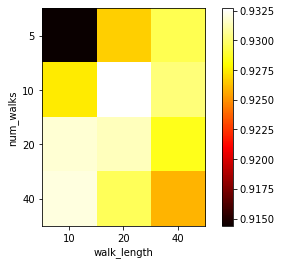

In [ ]:
plt.figure(figsize=(6, 4))
node_dim = 10
# you should have an auc score dictionary here.
a = np.array([[deepwalk_auc_scores[(node_dim, num_walks, walk_length)] for walk_length in [10, 20, 40]] for num_walks in [5, 10, 20, 40]])
plt.imshow(a, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.xticks(ticks=[0,1,2], labels=[10, 20, 40])
plt.xlabel("walk_length")
plt.yticks(ticks=[0,1,2,3], labels=[5, 10, 20, 40])
plt.ylabel("num_walks")

You can build model with the best parameters you find and save the prediction here.

In [ ]:
model = build_deepwalk(graph, alias_nodes, node_dim=10, num_walks=10, walk_length=10)
scores = [get_cosine_sim(model, src, dst) for src, dst in test_edges]
write_pred("data/pred.csv", test_edges, scores)

With the help of p and q, the node2vec model can fit training data better. And you can have a try if you set p=q=1, the two models will return the same results.

![Meaning of q and p](https://snap.stanford.edu/node2vec/walk.png)

#  Build Embedding Matrix

Convert nodes, edges to integers or their string-alias (to be compatible input of Word2Vec), then get the embedding by Node2Vec algorithm. There is no other node information, so we rely on this algorithm to construct embedding. Besides, we perform negative sampling to get train and valid negative links for supervised learning, in the manner that train positive, train negative, valid positive, valid negative, test set are disjoint.

**NOTE**: you can modify this part to adapt to your dataset, then be able to run later-introduced models directly.

In [14]:
train_file = "data/train.csv"
valid_file = "data/valid.csv"
test_file = "data/test.csv"

np.random.seed(0)
index2uid, uid2index, uid2ind, ind2uid = construct_uid_index(train_file)

train_edges = load_data(train_file, uid2index)
valid_edges = load_data(valid_file, uid2index)
test_edges = load_test_data(test_file, uid2index)

train_false_edges = generate_false_edges(train_edges+valid_edges+test_edges, 
                                         len(train_edges))
false_edges = generate_false_edges(train_edges+valid_edges+test_edges+train_false_edges, 
                                   40000-len(valid_edges))

graph = construct_graph_from_edges(train_edges)

8344 159149
8344 259149
number of nodes: 8343
number of edges: 100000


In [15]:
def convert_str_edges_to_tensor(edges):
    return torch.tensor([
        [int(x[0]) for x in edges],
        [int(x[1]) for x in edges]
    ])

train_pos_edges_T = convert_str_edges_to_tensor(train_edges)
train_neg_edges_T = convert_str_edges_to_tensor(train_false_edges)

valid_pos_edges_T = convert_str_edges_to_tensor(valid_edges)
valid_neg_edges_T = convert_str_edges_to_tensor(false_edges)
valid_labels = len(valid_pos_edges_T[0])*[1]+len(valid_neg_edges_T[0])*[0]

test_edges_T = convert_str_edges_to_tensor(test_edges)

print(train_pos_edges_T[0][0], train_pos_edges_T[1][0])

tensor(1) tensor(2155)


In [16]:
num_walks = 10
walk_length = 20
node_dim = 10
iter = 10
p, q = 1, 1

alias_nodes, alias_edges = preprocess_transition_probs(graph, p=p, q=q)
node2embs = build_node2vec(graph, alias_nodes, alias_edges, 
                           node_dim=node_dim, num_walks=num_walks, walk_length=walk_length)

get_auc_score(node2embs, valid_edges, false_edges)

building a node2vec model...	number of walks: 83430	average walk length: 19.9780	training time: 82.6285


0.9302033212807189

In [61]:
import pickle

data = [index2uid, uid2index, uid2ind, ind2uid,
        train_edges, valid_edges, train_false_edges, false_edges,
        node2embs]

with open('data/sage_src-afin_tar-afout_0.958/data_pickle', 'wb') as f:
    pickle.dump(data, f)

In [ ]:
# node2embs = dict()
# for node in index2uid.keys():
#     try:
#         node2embs[int(node)] = model.wv.get_vector(node)
#     except:
#         node2embs[int(node)] = np.array(10*[0.0])

# nx.relabel_nodes(graph, lambda x: int(x), copy=False)
# graph.add_node(0)
# nx.classes.function.set_node_attributes(graph, node2embs, name='x')
# G = from_networkx(graph)
# G

In [17]:
embs_matrix = []
num_nodes = len(index2uid.keys())

for i in range(num_nodes):
    try:
        embs_matrix.append(node2embs.wv.get_vector(str(i)))
    except:
        embs_matrix.append(np.array(node_dim*[0.0]))
        
embs_matrix = torch.Tensor(embs_matrix)
print(
    node2embs.wv['1'],
    embs_matrix[1],
    embs_matrix.shape,
    sep='\n'
)

# from torch_geometric.utils.convert import from_networkx
# from torch_geometric.data import Data
# dataset = Data(x=embs_matrix, edge_index=train_edges_T)

[ 1.2794923  -0.53844833  0.555468   -0.20640711  0.11952535 -2.159347
  0.58989125 -0.04979746 -1.8769317  -2.1608267 ]
tensor([ 1.2795, -0.5384,  0.5555, -0.2064,  0.1195, -2.1593,  0.5899, -0.0498,
        -1.8769, -2.1608])
torch.Size([8344, 10])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  # Remove the CWD from sys.path while we load stuff.


In [18]:
adj_matrix_src2tar = torch.zeros(num_nodes, num_nodes)
adj_matrix_src2tar[train_pos_edges_T[0], train_pos_edges_T[1]] = 1
adj_matrix_src2tar.T

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [19]:
def get_endpoints_embs(embs_matrix, edges_T, indices):
    list_src = edges_T[0][indices]
    list_tar = edges_T[1][indices]

    embs_src = embs_matrix[list_src]
    embs_tar = embs_matrix[list_tar]

    return embs_src, embs_tar

# MLP-aid

NOTE: run Convert NetworkX graph to PyG graph first

If cannot use PyG, have to do whole batch learning, because currently only PyG supports batch-learning for link prediction

Try plain MLP first, then add SAGE-like or Attention-like layer using their definition

**Usage:** you need to run 'Build Embedding Matrix' section first.

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import trange
import math

## Plain MLP

We build a simple MLP to transform embedding of each node. 

Theoretically, only pushing node embedding through a MLP w/o any message passing from neighbors (~ simple as a unary function) would not help, because it does not enrich the embedding spaces. Thus, we need later employ GraphSAGE mechanism.

About non-linear activation functions, we should not use common `ReLU` as it will destroy the cosine similarity (experimented, poor results). We have to use other activation functions, such as `tanh`.

Also, increasing the model size and alternating the cosine similarity decoder by l2-norm or sigmoid function seems decrease the model performance (experimented, but not the main focus hence not save result here).

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, 
                 num_hidden_layers=1, dropout=0.1, device=device):
        super(MLP, self).__init__()
        # (linear + relu) x n
        self.device = device
        self.num_layers = num_hidden_layers+2
        self.dropout = dropout

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, hidden_dim))

        for l in range(num_hidden_layers):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))

        self.layers.append(nn.Linear(hidden_dim, output_dim))
        self.twonode_fc = nn.Linear(2*output_dim, 1)

        self.reset_parameters()

    def reset_parameters(self):
        for layer in self.layers:
            layer.reset_parameters()
        self.twonode_fc.reset_parameters()

    def forward(self, x):
        x = x.to(self.device)

        for i in range(self.num_layers-1):
            x = self.layers[i](x)
            x = torch.tanh(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.layers[-1](x)       

        return x

    def decode(self, uv, metric='cosine'):
        u, v = uv
        assert u.shape == v.shape, "Tensors u and v must have the same 2d shape"

        u = F.normalize(self.forward(u))
        v = F.normalize(self.forward(v))

        if metric == 'cosine':
            return (u*v).sum(dim=1)
        elif metric == 'l2':
            return ((u-v)**2).sum(dim=1)
        elif metric == 'fc':
            temp = self.twonode_fc(torch.cat((u,v), dim=1))
            return torch.sigmoid(torch.squeeze(temp))
        else:
            raise NotImplementedError


In [ ]:
args =  {'input_dim': node_dim, 'hidden_dim': 32, 'output_dim': 16,
         'num_hidden_layers': 0, 'dropout': 0.0, 'metric': 'cosine',
         'epochs': 50, 'batch_size': 64, # half of actual batch size
         'weight_decay': 5e-3, 'lr': 0.001}

class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

args = objectview(args)

In [ ]:
# build model + optimizer
model = MLP(args.input_dim, args.hidden_dim, args.output_dim,
            args.num_hidden_layers, args.dropout).to(device)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
criterion = torch.nn.BCEWithLogitsLoss()

model.eval()
model(embs_matrix[1].to(device))

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=16, bias=True)
  )
  (twonode_fc): Linear(in_features=32, out_features=1, bias=True)
)


tensor([ 0.0412,  0.0953,  0.6567,  0.2362, -0.0102, -0.0726,  0.0573, -0.0227,
         0.1197, -0.3082, -0.2398,  0.6299,  0.0713,  0.3839, -0.0990,  0.2554],
       grad_fn=<AddBackward0>)

Epoch 0: 100%|██████████| 1562/1562 [00:04<00:00, 388.88steps/s]


auc score  0.9216417524388152
best auc 0.9216417524388152 achieved at epoch 0


Epoch 1: 100%|██████████| 1562/1562 [00:04<00:00, 380.37steps/s]


auc score  0.9228836993999172
best auc 0.9228836993999172 achieved at epoch 1


Epoch 2: 100%|██████████| 1562/1562 [00:04<00:00, 382.71steps/s]


auc score  0.923592664197385
best auc 0.923592664197385 achieved at epoch 2


Epoch 3: 100%|██████████| 1562/1562 [00:03<00:00, 390.67steps/s]


auc score  0.9241367325021734
best auc 0.9241367325021734 achieved at epoch 3


Epoch 4: 100%|██████████| 1562/1562 [00:06<00:00, 250.26steps/s]


auc score  0.924570273594323
best auc 0.924570273594323 achieved at epoch 4


Epoch 5: 100%|██████████| 1562/1562 [00:07<00:00, 217.47steps/s]


auc score  0.9248693378040985
best auc 0.9248693378040985 achieved at epoch 5


Epoch 6: 100%|██████████| 1562/1562 [00:04<00:00, 385.84steps/s]


auc score  0.9250389956923915
best auc 0.9250389956923915 achieved at epoch 6


Epoch 7: 100%|██████████| 1562/1562 [00:04<00:00, 390.17steps/s]


auc score  0.9251327316005724
best auc 0.9251327316005724 achieved at epoch 7


Epoch 8: 100%|██████████| 1562/1562 [00:04<00:00, 383.28steps/s]


auc score  0.9252260481955222
best auc 0.9252260481955222 achieved at epoch 8


Epoch 9: 100%|██████████| 1562/1562 [00:04<00:00, 383.21steps/s]


auc score  0.9253367306166407
best auc 0.9253367306166407 achieved at epoch 9


Epoch 10: 100%|██████████| 1562/1562 [00:04<00:00, 385.91steps/s]


auc score  0.9254842938268648
best auc 0.9254842938268648 achieved at epoch 10


Epoch 11: 100%|██████████| 1562/1562 [00:04<00:00, 383.19steps/s]


auc score  0.9256539592252454
best auc 0.9256539592252454 achieved at epoch 11


Epoch 12: 100%|██████████| 1562/1562 [00:04<00:00, 385.25steps/s]


auc score  0.9258380139516953
best auc 0.9258380139516953 achieved at epoch 12


Epoch 13: 100%|██████████| 1562/1562 [00:03<00:00, 391.96steps/s]


auc score  0.9260001191951056
best auc 0.9260001191951056 achieved at epoch 13


Epoch 14: 100%|██████████| 1562/1562 [00:04<00:00, 388.32steps/s]


auc score  0.9261483295245547
best auc 0.9261483295245547 achieved at epoch 14


Epoch 15: 100%|██████████| 1562/1562 [00:04<00:00, 388.80steps/s]


auc score  0.9262812718456718
best auc 0.9262812718456718 achieved at epoch 15


Epoch 16: 100%|██████████| 1562/1562 [00:03<00:00, 390.55steps/s]


auc score  0.926404074296687
best auc 0.926404074296687 achieved at epoch 16


Epoch 17: 100%|██████████| 1562/1562 [00:04<00:00, 378.29steps/s]


auc score  0.9265216772636382
best auc 0.9265216772636382 achieved at epoch 17


Epoch 18: 100%|██████████| 1562/1562 [00:04<00:00, 386.65steps/s]


auc score  0.9266410951684549
best auc 0.9266410951684549 achieved at epoch 18


Epoch 19: 100%|██████████| 1562/1562 [00:04<00:00, 387.53steps/s]


auc score  0.92675578296969
best auc 0.92675578296969 achieved at epoch 19


Epoch 20: 100%|██████████| 1562/1562 [00:04<00:00, 385.18steps/s]


auc score  0.9268620169155164
best auc 0.9268620169155164 achieved at epoch 20


Epoch 21: 100%|██████████| 1562/1562 [00:04<00:00, 318.96steps/s]


auc score  0.9269621814587845
best auc 0.9269621814587845 achieved at epoch 21


Epoch 22: 100%|██████████| 1562/1562 [00:04<00:00, 376.36steps/s]


auc score  0.9270542563858983
best auc 0.9270542563858983 achieved at epoch 22


Epoch 23: 100%|██████████| 1562/1562 [00:04<00:00, 388.97steps/s]


auc score  0.9271380276593577
best auc 0.9271380276593577 achieved at epoch 23


Epoch 24: 100%|██████████| 1562/1562 [00:04<00:00, 386.43steps/s]


auc score  0.9272129257641774
best auc 0.9272129257641774 achieved at epoch 24


Epoch 25: 100%|██████████| 1562/1562 [00:04<00:00, 377.74steps/s]


auc score  0.9272801372942167
best auc 0.9272801372942167 achieved at epoch 25


Epoch 26: 100%|██████████| 1562/1562 [00:04<00:00, 390.11steps/s]


auc score  0.9273412093275459
best auc 0.9273412093275459 achieved at epoch 26


Epoch 27: 100%|██████████| 1562/1562 [00:04<00:00, 375.47steps/s]


auc score  0.9273923355013729
best auc 0.9273923355013729 achieved at epoch 27


Epoch 28: 100%|██████████| 1562/1562 [00:04<00:00, 378.02steps/s]


auc score  0.9274372257990309
best auc 0.9274372257990309 achieved at epoch 28


Epoch 29: 100%|██████████| 1562/1562 [00:04<00:00, 388.99steps/s]


auc score  0.9274773834897446
best auc 0.9274773834897446 achieved at epoch 29


Epoch 30: 100%|██████████| 1562/1562 [00:03<00:00, 391.98steps/s]


auc score  0.9275127459894497
best auc 0.9275127459894497 achieved at epoch 30


Epoch 31: 100%|██████████| 1562/1562 [00:04<00:00, 378.18steps/s]


auc score  0.9275463361084533
best auc 0.9275463361084533 achieved at epoch 31


Epoch 32: 100%|██████████| 1562/1562 [00:04<00:00, 388.07steps/s]


auc score  0.9275737053714633
best auc 0.9275737053714633 achieved at epoch 32


Epoch 33: 100%|██████████| 1562/1562 [00:03<00:00, 393.04steps/s]


auc score  0.9275979554447074
best auc 0.9275979554447074 achieved at epoch 33


Epoch 34: 100%|██████████| 1562/1562 [00:04<00:00, 377.83steps/s]


auc score  0.9276225034180976
best auc 0.9276225034180976 achieved at epoch 34


Epoch 35: 100%|██████████| 1562/1562 [00:04<00:00, 387.89steps/s]


auc score  0.9276431699278185
best auc 0.9276431699278185 achieved at epoch 35


Epoch 36: 100%|██████████| 1562/1562 [00:04<00:00, 386.87steps/s]


auc score  0.9276604606531096
best auc 0.9276604606531096 achieved at epoch 36


Epoch 37: 100%|██████████| 1562/1562 [00:04<00:00, 383.20steps/s]


auc score  0.9276761654982109
best auc 0.9276761654982109 achieved at epoch 37


Epoch 38: 100%|██████████| 1562/1562 [00:04<00:00, 385.48steps/s]


auc score  0.9276924098179467
best auc 0.9276924098179467 achieved at epoch 38


Epoch 39: 100%|██████████| 1562/1562 [00:04<00:00, 387.32steps/s]


auc score  0.9277064086214546
best auc 0.9277064086214546 achieved at epoch 39


Epoch 40: 100%|██████████| 1562/1562 [00:04<00:00, 376.68steps/s]


auc score  0.9277194624055911
best auc 0.9277194624055911 achieved at epoch 40


Epoch 41: 100%|██████████| 1562/1562 [00:04<00:00, 386.89steps/s]


auc score  0.9277321406853416
best auc 0.9277321406853416 achieved at epoch 41


Epoch 42: 100%|██████████| 1562/1562 [00:03<00:00, 390.99steps/s]


auc score  0.9277413981201363
best auc 0.9277413981201363 achieved at epoch 42


Epoch 43: 100%|██████████| 1562/1562 [00:05<00:00, 271.79steps/s]


auc score  0.9277531025918462
best auc 0.9277531025918462 achieved at epoch 43


Epoch 44: 100%|██████████| 1562/1562 [00:04<00:00, 384.30steps/s]


auc score  0.9277632637405296
best auc 0.9277632637405296 achieved at epoch 44


Epoch 45: 100%|██████████| 1562/1562 [00:04<00:00, 379.54steps/s]


auc score  0.9277727439745935
best auc 0.9277727439745935 achieved at epoch 45


Epoch 46: 100%|██████████| 1562/1562 [00:04<00:00, 382.21steps/s]


auc score  0.9277820915304407
best auc 0.9277820915304407 achieved at epoch 46


Epoch 47: 100%|██████████| 1562/1562 [00:04<00:00, 383.82steps/s]


auc score  0.9277915592476917
best auc 0.9277915592476917 achieved at epoch 47


Epoch 48: 100%|██████████| 1562/1562 [00:04<00:00, 374.39steps/s]


auc score  0.9278014863319746
best auc 0.9278014863319746 achieved at epoch 48


Epoch 49: 100%|██████████| 1562/1562 [00:04<00:00, 380.98steps/s]


auc score  0.9278118014374563
best auc 0.9278118014374563 achieved at epoch 49


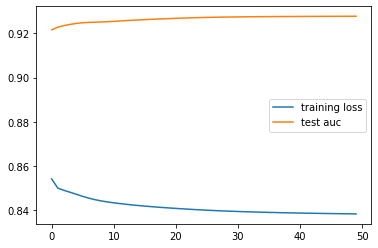

In [ ]:
from tqdm import trange
import math

# train
metric = args.metric   # fc, l2 are worse than cosine
losses = []
test_aucs = []
best_auc = 0
best_model = None
num_train_pairs = len(train_pos_edges_T[0])

for epoch in range(args.epochs):
    total_loss = 0
    model.train()
    
    for i in trange(math.floor(num_train_pairs/args.batch_size), desc="Epoch {}".format(epoch), unit="steps"):
        # list_index = args.batch_size*i:args.batch_size*(i+1)

        pred_pos = model.decode(
            get_endpoints_embs(embs_matrix, train_pos_edges_T, 
                               range(args.batch_size*i, args.batch_size*(i+1))
            ),
            metric=metric
        )

        pred_neg = model.decode(
            get_endpoints_embs(embs_matrix, train_neg_edges_T, 
                               range(args.batch_size*i, args.batch_size*(i+1))
            ),
            metric=metric
        )

        optimizer.zero_grad()
        pred = torch.cat((pred_pos, pred_neg), dim=0)
        label = torch.Tensor(args.batch_size*[1]+args.batch_size*[0]).to(device)
        loss = criterion(pred, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() 

    total_loss /= num_train_pairs
    losses.append(total_loss*100)

    if epoch % 1 == 0:
        test_auc = 0
        model.eval()

        with torch.no_grad():
            pred_pos = model.decode((embs_matrix[valid_pos_edges_T[0]],
                                            embs_matrix[valid_pos_edges_T[1]]),
                                    metric=metric)
            pred_neg = model.decode((embs_matrix[valid_neg_edges_T[0]],
                                            embs_matrix[valid_neg_edges_T[1]]),
                                    metric=metric)
        
            pred = torch.cat((pred_pos, pred_neg), dim=0).to('cpu')
            test_auc = roc_auc_score(valid_labels, pred)
            test_aucs.append(test_auc)
            print('auc score ', test_auc)

        if test_auc > best_auc:
            best_auc = test_auc
            print('best auc {} achieved at epoch {}'.format(best_auc, epoch))
            # best_model = copy.deepcopy(model)

    else:
        test_aucs.append(test_aucs[-1])

plt.plot(losses, label="training loss")
plt.plot(test_aucs, label="test auc")
plt.legend()
plt.show()


## GraphSAGE-like MLP

Based on plain MLP, we add adjacency matrix to perform message aggregation from neighbor. Since the graph is small enough (< 10k nodes) to do whole-batch forwarding with message aggregation (naive implementation, not advanced and optimized as implementation of PyTorch Geometric), we follow this direction.

Results related to adjacency matrix suggests that the first column (user id) is followee, the second column is followers, because passing message as src <- inbound neighbor, tar <- outbound neighbor represents the phenomenon as when a person A follows another person B, and B follows C, then A tends to also follow C

In [36]:
class GraphSAGE(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, adj_matrix_src2tar,
                 num_hidden_layers=1, dropout=0.1, device=device):
        super(GraphSAGE, self).__init__()
        # (linear + relu) x n
        self.device = device
        self.num_blocks = num_hidden_layers+1
        self.dropout = dropout

        self.adj_matrix_src2tar = adj_matrix_src2tar

        self.lin_s = nn.ModuleList()
        self.lin_t = nn.ModuleList()
        self.lin_st = nn.ModuleList()

        if num_hidden_layers > 0:
            self.lin_s.append(nn.Linear(input_dim, hidden_dim))
            self.lin_t.append(nn.Linear(input_dim, hidden_dim))
            self.lin_st.append(nn.Linear(2*hidden_dim, hidden_dim))

            for l in range(num_hidden_layers-1):
                self.lin_s.append(nn.Linear(hidden_dim, hidden_dim))
                self.lin_t.append(nn.Linear(hidden_dim, hidden_dim))
                self.lin_st.append(nn.Linear(2*hidden_dim, hidden_dim))

            self.lin_s.append(nn.Linear(hidden_dim, hidden_dim))
            self.lin_t.append(nn.Linear(hidden_dim, hidden_dim))
            self.lin_st.append(nn.Linear(2*hidden_dim, output_dim))

        else:
            self.lin_s.append(nn.Linear(input_dim, hidden_dim))
            self.lin_t.append(nn.Linear(input_dim, hidden_dim))
            self.lin_st.append(nn.Linear(2*hidden_dim, output_dim))

        self.reset_parameters()

    def reset_parameters(self):
        for i in range(self.num_blocks):
            self.lin_s[i].reset_parameters() 
            self.lin_t[i].reset_parameters() 
            self.lin_st[i].reset_parameters()

    def forward(self, x, src_or_tar='src', kernel='sum'):
        assert x.shape[0] == self.adj_matrix_src2tar.shape[0], "in whole-batch update, x must be embs_matrix"
        x = x.to(self.device)

        for i in range(self.num_blocks):
            source = self.lin_s[i](x)
            target = self.lin_t[i](x) 
            if src_or_tar=='src':
                # consider target as message passing to source
                aggreg = torch.matmul(self.adj_matrix_src2tar.T, target) # .T ~ inbound, not .T ~ outbound
                temp = torch.cat((source, aggreg), dim=1)
                # don't use tanh()
                x = self.lin_st[i](temp)
            elif src_or_tar=='tar':
                # consider source as message passing to target
                aggreg = torch.matmul(self.adj_matrix_src2tar, source) # .T ~ inbound, not .T ~ outbound
                temp = torch.cat((target, aggreg), dim=1)
                # don't use tanh()
                x = self.lin_st[i](temp)
            else:
                raise NotImplementedError

            # x = F.dropout(x, p=self.dropout, training=self.training)

        return x


**Results**

Fixed hyperparams in args: node_dim=10, ...

- Comparing models: to change the configuration, plz refer to line 51 and 56 of the above cell.

type|hidden_dim|output_dim|num_hidden_layers|auc| Achieved at epoch/total epoch
|--|--|--|--|--|--|
src<-out,tar<-out| 32 | 16 | 0 | 0.9546 | 5/5 |
src<-out,tar<-out (*)| 32 | 16 | 1 | 0.9529 | 10/10 |
src<-out,tar<-out| 16 | 16 | 0 | 0.9535 | 5/5 |
src<-in, tar<-out| 32 | 16 | 0 | **0.9576** | 5/5
src<-out, tar<-in| 32 | 16 | 0 | 0.9558 | 5/5
src<-in, tar<-out| 32 | 16 | 0 | 0.9551 | 5/5
src<-all, tar<-all| 32 | 16 | 0 | **0.9580** | 5/5

> (*) have more params to train, train more epoch for fair comparison

The result suggests that increase the size of model would not help, so we stick to the default agrs.

- Comparing the best 2 models with 10 epochs, we see no difference. Thus, as the (src<-in, tar<-out) model is more simple, we choose this to give scores for test data.

### src <- outbound neighbor, tar <- outbound neighbor

#### default hyperparams

Epoch 1: 100%|██████████| 1562/1562 [00:38<00:00, 40.71steps/s]


auc score  0.9539421878604335
best auc 0.9539421878604335 achieved at epoch 1


Epoch 2: 100%|██████████| 1562/1562 [00:38<00:00, 41.10steps/s]


auc score  0.9543324733506852
best auc 0.9543324733506852 achieved at epoch 2


Epoch 3: 100%|██████████| 1562/1562 [00:37<00:00, 41.43steps/s]


auc score  0.9544037891436631
best auc 0.9544037891436631 achieved at epoch 3


Epoch 4: 100%|██████████| 1562/1562 [00:37<00:00, 41.22steps/s]


auc score  0.9544930878416833
best auc 0.9544930878416833 achieved at epoch 4


Epoch 5: 100%|██████████| 1562/1562 [00:37<00:00, 41.51steps/s]


auc score  0.9545759391293971
best auc 0.9545759391293971 achieved at epoch 5


Epoch 6: 100%|██████████| 1562/1562 [00:37<00:00, 41.58steps/s]


auc score  0.9546443835655039
best auc 0.9546443835655039 achieved at epoch 6


Epoch 7: 100%|██████████| 1562/1562 [00:37<00:00, 41.60steps/s]


auc score  0.9546937811674742
best auc 0.9546937811674742 achieved at epoch 7


Epoch 8: 100%|██████████| 1562/1562 [00:37<00:00, 41.63steps/s]


auc score  0.9547273650280715
best auc 0.9547273650280715 achieved at epoch 8


Epoch 9: 100%|██████████| 1562/1562 [00:37<00:00, 41.59steps/s]


auc score  0.9547507101357453
best auc 0.9547507101357453 achieved at epoch 9


Epoch 10: 100%|██████████| 1562/1562 [00:37<00:00, 41.65steps/s]


auc score  0.9547654499345747
best auc 0.9547654499345747 achieved at epoch 10


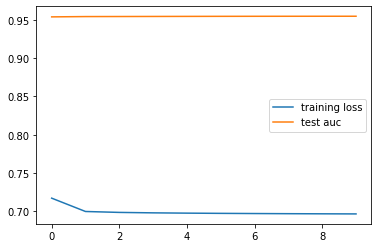

In [25]:
args =  {'input_dim': node_dim, 'hidden_dim': 32, 'output_dim': 16,
         'num_hidden_layers': 0, 'dropout': 0.0, 'metric': 'cosine',
         'epochs': 10,  'lr': 0.001, 'batch_size': 64, # half of actual batch size
         } 

class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

args = objectview(args)

# build model + optimizer
# src <- outbound neighbor, tar <- outbound neighbor
model = GraphSAGE(args.input_dim, args.hidden_dim, args.output_dim, adj_matrix_src2tar.to(device),
            args.num_hidden_layers, args.dropout).to(device)
# print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
criterion = torch.nn.BCEWithLogitsLoss()

# model.eval()
# model(embs_matrix)

# train
metric = args.metric   # fc, l2 are worse then cosine
losses = []
test_aucs = []
best_auc = 0
best_model = []
num_train_pairs = len(train_pos_edges_T[0])
embs_matrix = embs_matrix.to(device)

for epoch in range(1, args.epochs+1):
    total_loss = 0
    model.train()
    
    for i in trange(math.floor(num_train_pairs/args.batch_size), desc="Epoch {}".format(epoch), unit="steps"):
        # list_index = args.batch_size*i:args.batch_size*(i+1)

        source = F.normalize(model(embs_matrix, 'src'), dim=1)
        target = F.normalize(model(embs_matrix, 'tar'), dim=1)

        indices = range(args.batch_size*i, args.batch_size*(i+1))
        pos_u = source[train_pos_edges_T[0][indices]]
        pos_v = target[train_pos_edges_T[1][indices]]
        pred_pos = (pos_u*pos_v).sum(dim=1)

        neg_u = source[train_neg_edges_T[0][indices]]
        neg_v = target[train_neg_edges_T[1][indices]]
        pred_neg = (neg_u*neg_v).sum(dim=1)
        
        optimizer.zero_grad()
        pred = torch.cat((pred_pos, pred_neg), dim=0)
        label = torch.Tensor(args.batch_size*[1]+args.batch_size*[0]).to(device)
        loss = criterion(pred, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() 

    total_loss /= num_train_pairs
    losses.append(total_loss*100)

    if epoch % 1 == 0:
        test_auc = 0
        model.eval()

        with torch.no_grad():
            source = F.normalize(model(embs_matrix, 'src'), dim=1)
            target = F.normalize(model(embs_matrix, 'tar'), dim=1)

            pos_u = source[valid_pos_edges_T[0]]
            pos_v = target[valid_pos_edges_T[1]]
            pred_pos = (pos_u*pos_v).sum(dim=1)

            neg_u = source[valid_neg_edges_T[0]]
            neg_v = target[valid_neg_edges_T[1]]
            pred_neg = (neg_u*neg_v).sum(dim=1)
        
            pred = torch.cat((pred_pos, pred_neg), dim=0).to('cpu')
            test_auc = roc_auc_score(valid_labels, pred)
            test_aucs.append(test_auc)
            print('auc score ', test_auc)

        if test_auc > best_auc:
            best_auc = test_auc
            print('best auc {} achieved at epoch {}'.format(best_auc, epoch))
            # best_model = copy.deepcopy(model)

    else:
        test_aucs.append(test_aucs[-1])

plt.plot(losses, label="training loss")
plt.plot(test_aucs, label="test auc")
plt.legend()
plt.show()


#### 1 hidden layers

Epoch 1: 100%|██████████| 1562/1562 [01:14<00:00, 20.99steps/s]


auc score  0.9447377392379435
best auc 0.9447377392379435 achieved at epoch 1


Epoch 2: 100%|██████████| 1562/1562 [01:13<00:00, 21.22steps/s]


auc score  0.9467541790152223
best auc 0.9467541790152223 achieved at epoch 2


Epoch 3: 100%|██████████| 1562/1562 [01:12<00:00, 21.53steps/s]


auc score  0.9489349395117883
best auc 0.9489349395117883 achieved at epoch 3


Epoch 4: 100%|██████████| 1562/1562 [01:12<00:00, 21.50steps/s]


auc score  0.9507193250886439
best auc 0.9507193250886439 achieved at epoch 4


Epoch 5: 100%|██████████| 1562/1562 [01:12<00:00, 21.41steps/s]


auc score  0.9520591134725465
best auc 0.9520591134725465 achieved at epoch 5


Epoch 6: 100%|██████████| 1562/1562 [01:12<00:00, 21.52steps/s]


auc score  0.9526456788603731
best auc 0.9526456788603731 achieved at epoch 6


Epoch 7: 100%|██████████| 1562/1562 [01:15<00:00, 20.72steps/s]


auc score  0.9528484036648918
best auc 0.9528484036648918 achieved at epoch 7


Epoch 8: 100%|██████████| 1562/1562 [01:12<00:00, 21.58steps/s]


auc score  0.952894086276804
best auc 0.952894086276804 achieved at epoch 8


Epoch 9: 100%|██████████| 1562/1562 [01:12<00:00, 21.60steps/s]


auc score  0.9529014248841865
best auc 0.9529014248841865 achieved at epoch 9


Epoch 10: 100%|██████████| 1562/1562 [01:12<00:00, 21.58steps/s]


auc score  0.952920071180311
best auc 0.952920071180311 achieved at epoch 10


Epoch 11: 100%|██████████| 1562/1562 [01:12<00:00, 21.54steps/s]


auc score  0.9529602376327938
best auc 0.9529602376327938 achieved at epoch 11


Epoch 12: 100%|██████████| 1562/1562 [01:12<00:00, 21.58steps/s]


auc score  0.9530062844839602
best auc 0.9530062844839602 achieved at epoch 12


Epoch 13: 100%|██████████| 1562/1562 [01:12<00:00, 21.58steps/s]


auc score  0.953042370455449
best auc 0.953042370455449 achieved at epoch 13


Epoch 14: 100%|██████████| 1562/1562 [01:12<00:00, 21.43steps/s]


auc score  0.9530559624625389
best auc 0.9530559624625389 achieved at epoch 14


Epoch 15: 100%|██████████| 1562/1562 [01:12<00:00, 21.49steps/s]


auc score  0.9530632096971875
best auc 0.9530632096971875 achieved at epoch 15


Epoch 16: 100%|██████████| 1562/1562 [01:13<00:00, 21.24steps/s]


auc score  0.9530488791981387


Epoch 17: 100%|██████████| 1562/1562 [01:12<00:00, 21.50steps/s]


auc score  0.953035653933666


Epoch 18: 100%|██████████| 1562/1562 [01:12<00:00, 21.48steps/s]


auc score  0.9530343271515023


Epoch 19: 100%|██████████| 1562/1562 [01:12<00:00, 21.47steps/s]


auc score  0.9530226026528918


Epoch 20: 100%|██████████| 1562/1562 [01:14<00:00, 20.98steps/s]


auc score  0.9530129697137113


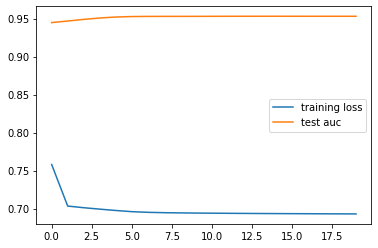

In [27]:
args =  {'input_dim': node_dim, 'hidden_dim': 32, 'output_dim': 16,
         'num_hidden_layers': 1, 'dropout': 0.0, 'metric': 'cosine',
         'epochs': 20,  'lr': 0.001, 'batch_size': 64, # half of actual batch size
         }      # 20 epochs would not help. just train 10 epochs


class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

args = objectview(args)

# build model + optimizer
# src <- outbound neighbor, tar <- outbound neighbor
model = GraphSAGE(args.input_dim, args.hidden_dim, args.output_dim, adj_matrix_src2tar.to(device),
            args.num_hidden_layers, args.dropout).to(device)
# print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
criterion = torch.nn.BCEWithLogitsLoss()

# model.eval()
# model(embs_matrix)

# train
metric = args.metric   # fc, l2 are worse then cosine
losses = []
test_aucs = []
best_auc = 0
best_model = []
num_train_pairs = len(train_pos_edges_T[0])
embs_matrix = embs_matrix.to(device)

for epoch in range(1, args.epochs+1):
    total_loss = 0
    model.train()
    
    for i in trange(math.floor(num_train_pairs/args.batch_size), desc="Epoch {}".format(epoch), unit="steps"):
        # list_index = args.batch_size*i:args.batch_size*(i+1)

        source = F.normalize(model(embs_matrix, 'src'), dim=1)
        target = F.normalize(model(embs_matrix, 'tar'), dim=1)

        indices = range(args.batch_size*i, args.batch_size*(i+1))
        pos_u = source[train_pos_edges_T[0][indices]]
        pos_v = target[train_pos_edges_T[1][indices]]
        pred_pos = (pos_u*pos_v).sum(dim=1)

        neg_u = source[train_neg_edges_T[0][indices]]
        neg_v = target[train_neg_edges_T[1][indices]]
        pred_neg = (neg_u*neg_v).sum(dim=1)
        
        optimizer.zero_grad()
        pred = torch.cat((pred_pos, pred_neg), dim=0)
        label = torch.Tensor(args.batch_size*[1]+args.batch_size*[0]).to(device)
        loss = criterion(pred, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() 

    total_loss /= num_train_pairs
    losses.append(total_loss*100)

    if epoch % 1 == 0:
        test_auc = 0
        model.eval()

        with torch.no_grad():
            source = F.normalize(model(embs_matrix, 'src'), dim=1)
            target = F.normalize(model(embs_matrix, 'tar'), dim=1)

            pos_u = source[valid_pos_edges_T[0]]
            pos_v = target[valid_pos_edges_T[1]]
            pred_pos = (pos_u*pos_v).sum(dim=1)

            neg_u = source[valid_neg_edges_T[0]]
            neg_v = target[valid_neg_edges_T[1]]
            pred_neg = (neg_u*neg_v).sum(dim=1)
        
            pred = torch.cat((pred_pos, pred_neg), dim=0).to('cpu')
            test_auc = roc_auc_score(valid_labels, pred)
            test_aucs.append(test_auc)
            print('auc score ', test_auc)

        if test_auc > best_auc:
            best_auc = test_auc
            print('best auc {} achieved at epoch {}'.format(best_auc, epoch))
            # best_model = copy.deepcopy(model)

    else:
        test_aucs.append(test_aucs[-1])

plt.plot(losses, label="training loss")
plt.plot(test_aucs, label="test auc")
plt.legend()
plt.show()

#### hidden_dim=16

Epoch 1: 100%|██████████| 1562/1562 [00:38<00:00, 40.35steps/s]


auc score  0.9515208517172458
best auc 0.9515208517172458 achieved at epoch 1


Epoch 2: 100%|██████████| 1562/1562 [00:41<00:00, 37.78steps/s]


auc score  0.9521806179300676
best auc 0.9521806179300676 achieved at epoch 2


Epoch 3: 100%|██████████| 1562/1562 [00:38<00:00, 40.35steps/s]


auc score  0.9527318683820779
best auc 0.9527318683820779 achieved at epoch 3


Epoch 4: 100%|██████████| 1562/1562 [00:36<00:00, 42.76steps/s]


auc score  0.9531557827934533
best auc 0.9531557827934533 achieved at epoch 4


Epoch 5: 100%|██████████| 1562/1562 [00:36<00:00, 42.62steps/s]


auc score  0.9534954527958431
best auc 0.9534954527958431 achieved at epoch 5


Epoch 6: 100%|██████████| 1562/1562 [00:37<00:00, 42.17steps/s]


auc score  0.9537616816504307
best auc 0.9537616816504307 achieved at epoch 6


Epoch 7: 100%|██████████| 1562/1562 [00:37<00:00, 42.12steps/s]


auc score  0.9539664692257096
best auc 0.9539664692257096 achieved at epoch 7


Epoch 8: 100%|██████████| 1562/1562 [00:36<00:00, 42.77steps/s]


auc score  0.954126739504354
best auc 0.954126739504354 achieved at epoch 8


Epoch 9: 100%|██████████| 1562/1562 [00:41<00:00, 37.74steps/s]


auc score  0.9542521016436001
best auc 0.9542521016436001 achieved at epoch 9


Epoch 10: 100%|██████████| 1562/1562 [00:36<00:00, 42.79steps/s]


auc score  0.9543521059716635
best auc 0.9543521059716635 achieved at epoch 10


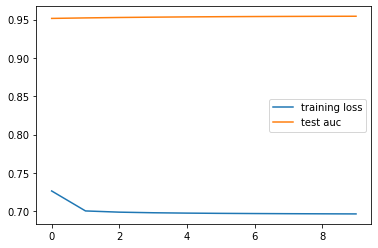

In [29]:
args =  {'input_dim': node_dim, 'hidden_dim': 16, 'output_dim': 16,
         'num_hidden_layers': 0, 'dropout': 0.0, 'metric': 'cosine',
         'epochs': 10,  'lr': 0.001, 'batch_size': 64, # half of actual batch size
         }

class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

args = objectview(args)

# build model + optimizer
# src <- outbound neighbor, tar <- outbound neighbor
model = GraphSAGE(args.input_dim, args.hidden_dim, args.output_dim, adj_matrix_src2tar.to(device),
            args.num_hidden_layers, args.dropout).to(device)
# print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
criterion = torch.nn.BCEWithLogitsLoss()

# model.eval()
# model(embs_matrix)

# train
metric = args.metric   # fc, l2 are worse then cosine
losses = []
test_aucs = []
best_auc = 0
best_model = []
num_train_pairs = len(train_pos_edges_T[0])
embs_matrix = embs_matrix.to(device)

for epoch in range(1, args.epochs+1):
    total_loss = 0
    model.train()
    
    for i in trange(math.floor(num_train_pairs/args.batch_size), desc="Epoch {}".format(epoch), unit="steps"):
        # list_index = args.batch_size*i:args.batch_size*(i+1)

        source = F.normalize(model(embs_matrix, 'src'), dim=1)
        target = F.normalize(model(embs_matrix, 'tar'), dim=1)

        indices = range(args.batch_size*i, args.batch_size*(i+1))
        pos_u = source[train_pos_edges_T[0][indices]]
        pos_v = target[train_pos_edges_T[1][indices]]
        pred_pos = (pos_u*pos_v).sum(dim=1)

        neg_u = source[train_neg_edges_T[0][indices]]
        neg_v = target[train_neg_edges_T[1][indices]]
        pred_neg = (neg_u*neg_v).sum(dim=1)
        
        optimizer.zero_grad()
        pred = torch.cat((pred_pos, pred_neg), dim=0)
        label = torch.Tensor(args.batch_size*[1]+args.batch_size*[0]).to(device)
        loss = criterion(pred, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() 

    total_loss /= num_train_pairs
    losses.append(total_loss*100)

    if epoch % 1 == 0:
        test_auc = 0
        model.eval()

        with torch.no_grad():
            source = F.normalize(model(embs_matrix, 'src'), dim=1)
            target = F.normalize(model(embs_matrix, 'tar'), dim=1)

            pos_u = source[valid_pos_edges_T[0]]
            pos_v = target[valid_pos_edges_T[1]]
            pred_pos = (pos_u*pos_v).sum(dim=1)

            neg_u = source[valid_neg_edges_T[0]]
            neg_v = target[valid_neg_edges_T[1]]
            pred_neg = (neg_u*neg_v).sum(dim=1)
        
            pred = torch.cat((pred_pos, pred_neg), dim=0).to('cpu')
            test_auc = roc_auc_score(valid_labels, pred)
            test_aucs.append(test_auc)
            print('auc score ', test_auc)

        if test_auc > best_auc:
            best_auc = test_auc
            print('best auc {} achieved at epoch {}'.format(best_auc, epoch))
            # best_model = copy.deepcopy(model)

    else:
        test_aucs.append(test_aucs[-1])

plt.plot(losses, label="training loss")
plt.plot(test_aucs, label="test auc")
plt.legend()
plt.show()


### src <- inbound neighbor, tar <- outbound neighbor

Epoch 1: 100%|██████████| 1562/1562 [00:37<00:00, 41.58steps/s]


auc score  0.957042538571266
best auc 0.957042538571266 achieved at epoch 1


Epoch 2: 100%|██████████| 1562/1562 [00:37<00:00, 41.71steps/s]


auc score  0.9571695842218424
best auc 0.9571695842218424 achieved at epoch 2


Epoch 3: 100%|██████████| 1562/1562 [00:37<00:00, 41.72steps/s]


auc score  0.9573185192747566
best auc 0.9573185192747566 achieved at epoch 3


Epoch 4: 100%|██████████| 1562/1562 [00:37<00:00, 41.71steps/s]


auc score  0.9574744562327872
best auc 0.9574744562327872 achieved at epoch 4


Epoch 5: 100%|██████████| 1562/1562 [00:37<00:00, 41.72steps/s]


auc score  0.9576272051585812
best auc 0.9576272051585812 achieved at epoch 5


Epoch 6: 100%|██████████| 1562/1562 [00:37<00:00, 41.65steps/s]


auc score  0.9577660091031627
best auc 0.9577660091031627 achieved at epoch 6


Epoch 7: 100%|██████████| 1562/1562 [00:37<00:00, 41.70steps/s]


auc score  0.9578755312157283
best auc 0.9578755312157283 achieved at epoch 7


Epoch 8: 100%|██████████| 1562/1562 [00:37<00:00, 41.69steps/s]


auc score  0.9579550467728137
best auc 0.9579550467728137 achieved at epoch 8


Epoch 9: 100%|██████████| 1562/1562 [00:37<00:00, 41.61steps/s]


auc score  0.9580091394312896
best auc 0.9580091394312896 achieved at epoch 9


Epoch 10: 100%|██████████| 1562/1562 [00:37<00:00, 41.71steps/s]


auc score  0.9580409396460536
best auc 0.9580409396460536 achieved at epoch 10


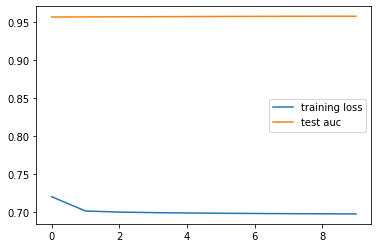

In [37]:
args =  {'input_dim': node_dim, 'hidden_dim': 32, 'output_dim': 16,
         'num_hidden_layers': 0, 'dropout': 0.0, 'metric': 'cosine',
         'epochs': 10,  'lr': 0.001, 'batch_size': 64, # half of actual batch size
         }

class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

args = objectview(args)

# build model + optimizer
# src <- inbound neighbor, tar <- outbound neighbor
model = GraphSAGE(args.input_dim, args.hidden_dim, args.output_dim, adj_matrix_src2tar.to(device),
            args.num_hidden_layers, args.dropout).to(device)
# print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
criterion = torch.nn.BCEWithLogitsLoss()

# model.eval()
# model(embs_matrix)

# train
metric = args.metric   # fc, l2 are worse then cosine
losses = []
test_aucs = []
best_auc = 0
best_model = []
num_train_pairs = len(train_pos_edges_T[0])
embs_matrix = embs_matrix.to(device)

for epoch in range(1, args.epochs+1):
    total_loss = 0
    model.train()
    
    for i in trange(math.floor(num_train_pairs/args.batch_size), desc="Epoch {}".format(epoch), unit="steps"):
        # list_index = args.batch_size*i:args.batch_size*(i+1)

        source = F.normalize(model(embs_matrix, 'src'), dim=1)
        target = F.normalize(model(embs_matrix, 'tar'), dim=1)

        indices = range(args.batch_size*i, args.batch_size*(i+1))
        pos_u = source[train_pos_edges_T[0][indices]]
        pos_v = target[train_pos_edges_T[1][indices]]
        pred_pos = (pos_u*pos_v).sum(dim=1)

        neg_u = source[train_neg_edges_T[0][indices]]
        neg_v = target[train_neg_edges_T[1][indices]]
        pred_neg = (neg_u*neg_v).sum(dim=1)
        
        optimizer.zero_grad()
        pred = torch.cat((pred_pos, pred_neg), dim=0)
        label = torch.Tensor(args.batch_size*[1]+args.batch_size*[0]).to(device)
        loss = criterion(pred, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() 

    total_loss /= num_train_pairs
    losses.append(total_loss*100)

    if epoch % 1 == 0:
        test_auc = 0
        model.eval()

        with torch.no_grad():
            source = F.normalize(model(embs_matrix, 'src'), dim=1)
            target = F.normalize(model(embs_matrix, 'tar'), dim=1)

            pos_u = source[valid_pos_edges_T[0]]
            pos_v = target[valid_pos_edges_T[1]]
            pred_pos = (pos_u*pos_v).sum(dim=1)

            neg_u = source[valid_neg_edges_T[0]]
            neg_v = target[valid_neg_edges_T[1]]
            pred_neg = (neg_u*neg_v).sum(dim=1)
        
            pred = torch.cat((pred_pos, pred_neg), dim=0).to('cpu')
            test_auc = roc_auc_score(valid_labels, pred)
            test_aucs.append(test_auc)
            print('auc score ', test_auc)

        if test_auc > best_auc:
            best_auc = test_auc
            print('best auc {} achieved at epoch {}'.format(best_auc, epoch))
            # best_model = copy.deepcopy(model)

    else:
        test_aucs.append(test_aucs[-1])

plt.plot(losses, label="training loss")
plt.plot(test_aucs, label="test auc")
plt.legend()
plt.show()


previous run's result

```
Epoch 1: 100%|██████████| 1562/1562 [00:37<00:00, 41.44steps/s]
auc score  0.9568289341530052
best auc 0.9568289341530052 achieved at epoch 1
Epoch 2: 100%|██████████| 1562/1562 [00:40<00:00, 38.11steps/s]
auc score  0.9577462337905177
best auc 0.9577462337905177 achieved at epoch 2
Epoch 3: 100%|██████████| 1562/1562 [00:40<00:00, 38.79steps/s]
auc score  0.9579914994869195
best auc 0.9579914994869195 achieved at epoch 3
```

### src <- inbound neighbor, tar <- inbound neighbor

Epoch 1: 100%|██████████| 1562/1562 [00:41<00:00, 37.61steps/s]


auc score  0.9546661465480315
best auc 0.9546661465480315 achieved at epoch 1


Epoch 2: 100%|██████████| 1562/1562 [00:40<00:00, 38.93steps/s]


auc score  0.955328515006248
best auc 0.955328515006248 achieved at epoch 2


Epoch 3: 100%|██████████| 1562/1562 [00:39<00:00, 39.11steps/s]


auc score  0.9555514644769935
best auc 0.9555514644769935 achieved at epoch 3


Epoch 4: 100%|██████████| 1562/1562 [00:40<00:00, 38.80steps/s]


auc score  0.9556790646223796
best auc 0.9556790646223796 achieved at epoch 4


Epoch 5: 100%|██████████| 1562/1562 [00:39<00:00, 39.58steps/s]


auc score  0.9557546636687198
best auc 0.9557546636687198 achieved at epoch 5


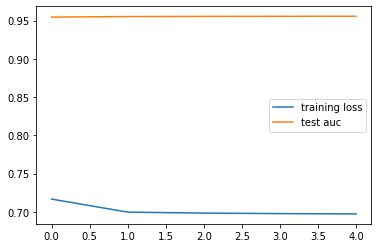

In [33]:
args =  {'input_dim': node_dim, 'hidden_dim': 32, 'output_dim': 16,
         'num_hidden_layers': 0, 'dropout': 0.0, 'metric': 'cosine',
         'epochs': 5,  'lr': 0.001, 'batch_size': 64, # half of actual batch size
         }

class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

args = objectview(args)

# build model + optimizer
# src <- outbound neighbor, tar <- bound neighbor
model = GraphSAGE(args.input_dim, args.hidden_dim, args.output_dim, adj_matrix_src2tar.to(device),
            args.num_hidden_layers, args.dropout).to(device)
# print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
criterion = torch.nn.BCEWithLogitsLoss()

# model.eval()
# model(embs_matrix)

# train
metric = args.metric   # fc, l2 are worse then cosine
losses = []
test_aucs = []
best_auc = 0
best_model = []
num_train_pairs = len(train_pos_edges_T[0])
embs_matrix = embs_matrix.to(device)

for epoch in range(1, args.epochs+1):
    total_loss = 0
    model.train()
    
    for i in trange(math.floor(num_train_pairs/args.batch_size), desc="Epoch {}".format(epoch), unit="steps"):
        # list_index = args.batch_size*i:args.batch_size*(i+1)

        source = F.normalize(model(embs_matrix, 'src'), dim=1)
        target = F.normalize(model(embs_matrix, 'tar'), dim=1)

        indices = range(args.batch_size*i, args.batch_size*(i+1))
        pos_u = source[train_pos_edges_T[0][indices]]
        pos_v = target[train_pos_edges_T[1][indices]]
        pred_pos = (pos_u*pos_v).sum(dim=1)

        neg_u = source[train_neg_edges_T[0][indices]]
        neg_v = target[train_neg_edges_T[1][indices]]
        pred_neg = (neg_u*neg_v).sum(dim=1)
        
        optimizer.zero_grad()
        pred = torch.cat((pred_pos, pred_neg), dim=0)
        label = torch.Tensor(args.batch_size*[1]+args.batch_size*[0]).to(device)
        loss = criterion(pred, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() 

    total_loss /= num_train_pairs
    losses.append(total_loss*100)

    if epoch % 1 == 0:
        test_auc = 0
        model.eval()

        with torch.no_grad():
            source = F.normalize(model(embs_matrix, 'src'), dim=1)
            target = F.normalize(model(embs_matrix, 'tar'), dim=1)

            pos_u = source[valid_pos_edges_T[0]]
            pos_v = target[valid_pos_edges_T[1]]
            pred_pos = (pos_u*pos_v).sum(dim=1)

            neg_u = source[valid_neg_edges_T[0]]
            neg_v = target[valid_neg_edges_T[1]]
            pred_neg = (neg_u*neg_v).sum(dim=1)
        
            pred = torch.cat((pred_pos, pred_neg), dim=0).to('cpu')
            test_auc = roc_auc_score(valid_labels, pred)
            test_aucs.append(test_auc)
            print('auc score ', test_auc)

        if test_auc > best_auc:
            best_auc = test_auc
            print('best auc {} achieved at epoch {}'.format(best_auc, epoch))
            # best_model = copy.deepcopy(model)

    else:
        test_aucs.append(test_aucs[-1])

plt.plot(losses, label="training loss")
plt.plot(test_aucs, label="test auc")
plt.legend()
plt.show()


### src <- outbound neighbor, tar <- inbound neighbor

Epoch 1: 100%|██████████| 1562/1562 [00:38<00:00, 40.25steps/s]


auc score  0.9500450406245804
best auc 0.9500450406245804 achieved at epoch 1


Epoch 2: 100%|██████████| 1562/1562 [00:38<00:00, 40.80steps/s]


auc score  0.9509361275525914
best auc 0.9509361275525914 achieved at epoch 2


Epoch 3: 100%|██████████| 1562/1562 [00:38<00:00, 40.08steps/s]


auc score  0.9513601896623588
best auc 0.9513601896623588 achieved at epoch 3


Epoch 4: 100%|██████████| 1562/1562 [00:37<00:00, 41.33steps/s]


auc score  0.9516698305790048
best auc 0.9516698305790048 achieved at epoch 4


Epoch 5: 100%|██████████| 1562/1562 [00:37<00:00, 41.36steps/s]


auc score  0.9518925559988001
best auc 0.9518925559988001 achieved at epoch 5


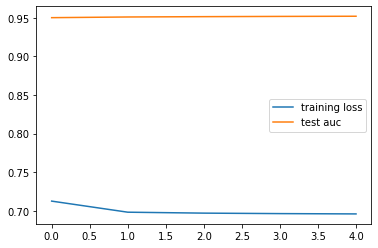

In [35]:
args =  {'input_dim': node_dim, 'hidden_dim': 32, 'output_dim': 16,
         'num_hidden_layers': 0, 'dropout': 0.0, 'metric': 'cosine',
         'epochs': 5,  'lr': 0.001, 'batch_size': 64, # half of actual batch size
         }

class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

args = objectview(args)

# build model + optimizer
# src <- outbound neighbor, tar <- bound neighbor
model = GraphSAGE(args.input_dim, args.hidden_dim, args.output_dim, adj_matrix_src2tar.to(device),
            args.num_hidden_layers, args.dropout).to(device)
# print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
criterion = torch.nn.BCEWithLogitsLoss()

# model.eval()
# model(embs_matrix)

# train
metric = args.metric   # fc, l2 are worse then cosine
losses = []
test_aucs = []
best_auc = 0
best_model = []
num_train_pairs = len(train_pos_edges_T[0])
embs_matrix = embs_matrix.to(device)

for epoch in range(1, args.epochs+1):
    total_loss = 0
    model.train()
    
    for i in trange(math.floor(num_train_pairs/args.batch_size), desc="Epoch {}".format(epoch), unit="steps"):
        # list_index = args.batch_size*i:args.batch_size*(i+1)

        source = F.normalize(model(embs_matrix, 'src'), dim=1)
        target = F.normalize(model(embs_matrix, 'tar'), dim=1)

        indices = range(args.batch_size*i, args.batch_size*(i+1))
        pos_u = source[train_pos_edges_T[0][indices]]
        pos_v = target[train_pos_edges_T[1][indices]]
        pred_pos = (pos_u*pos_v).sum(dim=1)

        neg_u = source[train_neg_edges_T[0][indices]]
        neg_v = target[train_neg_edges_T[1][indices]]
        pred_neg = (neg_u*neg_v).sum(dim=1)
        
        optimizer.zero_grad()
        pred = torch.cat((pred_pos, pred_neg), dim=0)
        label = torch.Tensor(args.batch_size*[1]+args.batch_size*[0]).to(device)
        loss = criterion(pred, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() 

    total_loss /= num_train_pairs
    losses.append(total_loss*100)

    if epoch % 1 == 0:
        test_auc = 0
        model.eval()

        with torch.no_grad():
            source = F.normalize(model(embs_matrix, 'src'), dim=1)
            target = F.normalize(model(embs_matrix, 'tar'), dim=1)

            pos_u = source[valid_pos_edges_T[0]]
            pos_v = target[valid_pos_edges_T[1]]
            pred_pos = (pos_u*pos_v).sum(dim=1)

            neg_u = source[valid_neg_edges_T[0]]
            neg_v = target[valid_neg_edges_T[1]]
            pred_neg = (neg_u*neg_v).sum(dim=1)
        
            pred = torch.cat((pred_pos, pred_neg), dim=0).to('cpu')
            test_auc = roc_auc_score(valid_labels, pred)
            test_aucs.append(test_auc)
            print('auc score ', test_auc)

        if test_auc > best_auc:
            best_auc = test_auc
            print('best auc {} achieved at epoch {}'.format(best_auc, epoch))
            # best_model = copy.deepcopy(model)

    else:
        test_aucs.append(test_aucs[-1])

plt.plot(losses, label="training loss")
plt.plot(test_aucs, label="test auc")
plt.legend()
plt.show()


### src <- both in-out neighbor, tar <- both in-out neighbor

In [41]:
adj_matrix_src2tar_both_di = torch.zeros(num_nodes, num_nodes)
adj_matrix_src2tar_both_di[train_pos_edges_T[0], train_pos_edges_T[1]] = 1
adj_matrix_src2tar_both_di[train_pos_edges_T[1], train_pos_edges_T[0]] = 1
adj_matrix_src2tar_both_di.T

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [44]:
print(sum(sum(adj_matrix_src2tar_both_di)),
      sum(sum(adj_matrix_src2tar))
      )

tensor(127826.) tensor(100000.)


Epoch 1: 100%|██████████| 1562/1562 [00:40<00:00, 38.24steps/s]


auc score  0.9572377858317794
best auc 0.9572377858317794 achieved at epoch 1


Epoch 2: 100%|██████████| 1562/1562 [00:37<00:00, 41.92steps/s]


auc score  0.9575816777551484
best auc 0.9575816777551484 achieved at epoch 2


Epoch 3: 100%|██████████| 1562/1562 [00:37<00:00, 41.82steps/s]


auc score  0.9577743690824748
best auc 0.9577743690824748 achieved at epoch 3


Epoch 4: 100%|██████████| 1562/1562 [00:38<00:00, 41.04steps/s]


auc score  0.9578970951809316
best auc 0.9578970951809316 achieved at epoch 4


Epoch 5: 100%|██████████| 1562/1562 [00:38<00:00, 40.92steps/s]


auc score  0.9579759673738357
best auc 0.9579759673738357 achieved at epoch 5


Epoch 6: 100%|██████████| 1562/1562 [00:37<00:00, 41.82steps/s]


auc score  0.9580264289048998
best auc 0.9580264289048998 achieved at epoch 6


Epoch 7: 100%|██████████| 1562/1562 [00:37<00:00, 41.85steps/s]


auc score  0.9580552088127193
best auc 0.9580552088127193 achieved at epoch 7


Epoch 8: 100%|██████████| 1562/1562 [00:37<00:00, 41.84steps/s]


auc score  0.9580695005096483
best auc 0.9580695005096483 achieved at epoch 8


Epoch 9: 100%|██████████| 1562/1562 [00:37<00:00, 41.75steps/s]


auc score  0.958073793776461
best auc 0.958073793776461 achieved at epoch 9


Epoch 10: 100%|██████████| 1562/1562 [00:37<00:00, 41.81steps/s]


auc score  0.9580713630114025


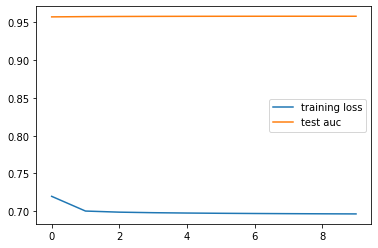

In [46]:
args =  {'input_dim': node_dim, 'hidden_dim': 32, 'output_dim': 16,
         'num_hidden_layers': 0, 'dropout': 0.0, 'metric': 'cosine',
         'epochs': 10,  'lr': 0.001, 'batch_size': 64, # half of actual batch size
         }

class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

args = objectview(args)

# build model + optimizer
# src <- both neighbor, tar <- both neighbor
model = GraphSAGE(args.input_dim, args.hidden_dim, args.output_dim, adj_matrix_src2tar_both_di.to(device),
            args.num_hidden_layers, args.dropout).to(device)
# print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
criterion = torch.nn.BCEWithLogitsLoss()

# model.eval()
# model(embs_matrix)

# train
metric = args.metric   # fc, l2 are worse then cosine
losses = []
test_aucs = []
best_auc = 0
best_model = []
num_train_pairs = len(train_pos_edges_T[0])
embs_matrix = embs_matrix.to(device)

for epoch in range(1, args.epochs+1):
    total_loss = 0
    model.train()
    
    for i in trange(math.floor(num_train_pairs/args.batch_size), desc="Epoch {}".format(epoch), unit="steps"):
        # list_index = args.batch_size*i:args.batch_size*(i+1)

        source = F.normalize(model(embs_matrix, 'src'), dim=1)
        target = F.normalize(model(embs_matrix, 'tar'), dim=1)

        indices = range(args.batch_size*i, args.batch_size*(i+1))
        pos_u = source[train_pos_edges_T[0][indices]]
        pos_v = target[train_pos_edges_T[1][indices]]
        pred_pos = (pos_u*pos_v).sum(dim=1)

        neg_u = source[train_neg_edges_T[0][indices]]
        neg_v = target[train_neg_edges_T[1][indices]]
        pred_neg = (neg_u*neg_v).sum(dim=1)
        
        optimizer.zero_grad()
        pred = torch.cat((pred_pos, pred_neg), dim=0)
        label = torch.Tensor(args.batch_size*[1]+args.batch_size*[0]).to(device)
        loss = criterion(pred, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() 

    total_loss /= num_train_pairs
    losses.append(total_loss*100)

    if epoch % 1 == 0:
        test_auc = 0
        model.eval()

        with torch.no_grad():
            source = F.normalize(model(embs_matrix, 'src'), dim=1)
            target = F.normalize(model(embs_matrix, 'tar'), dim=1)

            pos_u = source[valid_pos_edges_T[0]]
            pos_v = target[valid_pos_edges_T[1]]
            pred_pos = (pos_u*pos_v).sum(dim=1)

            neg_u = source[valid_neg_edges_T[0]]
            neg_v = target[valid_neg_edges_T[1]]
            pred_neg = (neg_u*neg_v).sum(dim=1)
        
            pred = torch.cat((pred_pos, pred_neg), dim=0).to('cpu')
            test_auc = roc_auc_score(valid_labels, pred)
            test_aucs.append(test_auc)
            print('auc score ', test_auc)

        if test_auc > best_auc:
            best_auc = test_auc
            print('best auc {} achieved at epoch {}'.format(best_auc, epoch))
            # best_model = copy.deepcopy(model)

    else:
        test_aucs.append(test_aucs[-1])

plt.plot(losses, label="training loss")
plt.plot(test_aucs, label="test auc")
plt.legend()
plt.show()



```
Epoch 1: 100%|██████████| 1562/1562 [00:38<00:00, 40.66steps/s]
auc score  0.9575397451803705
best auc 0.9575397451803705 achieved at epoch 1
Epoch 2: 100%|██████████| 1562/1562 [00:37<00:00, 41.70steps/s]
auc score  0.9577850546856175
best auc 0.9577850546856175 achieved at epoch 2
Epoch 3: 100%|██████████| 1562/1562 [00:37<00:00, 41.78steps/s]
auc score  0.9578927042829787
best auc 0.9578927042829787 achieved at epoch 3
Epoch 4: 100%|██████████| 1562/1562 [00:37<00:00, 41.54steps/s]
auc score  0.9579827402212768
best auc 0.9579827402212768 achieved at epoch 4
Epoch 5: 100%|██████████| 1562/1562 [00:37<00:00, 41.91steps/s]
auc score  0.9580494285485385
best auc 0.9580494285485385 achieved at epoch 5
```

### Prediction

In [38]:
# prediction
def get_test_scores(test_edges_T):
    model.eval()
    with torch.no_grad():
        source = F.normalize(model(embs_matrix, 'src'), dim=1)
        target = F.normalize(model(embs_matrix, 'tar'), dim=1)

        u = source[test_edges_T[0]]
        v = target[test_edges_T[1]]
        pred = (u*v).sum(dim=1).to('cpu')
    return pred

# test_edges = load_test_data(test_file, uid2index)
# test_edges_T = convert_str_edges_to_tensor(test_edges)
scores = get_test_scores(test_edges_T)
print(scores)

# check the order of test_edges_T
assert ind2uid[int(test_edges_T[0][0])] ==  'NfU0zDaTMEQ4-X9dbQWd9A'
assert ind2uid[int(test_edges_T[1][20])] ==  'AOcBQ6FZAfeHX6P7JvwRcA'

df = pd.read_csv('data/test.csv')
df["score"] = scores

save_info = 'sage_src-afin_tar-afout_0.958'
os.mkdir(f'data/{save_info}')
df.to_csv(f'data/{save_info}/pred.csv', index=False)
torch.save(model.state_dict(), f'data/{save_info}/best_sage_checkpoint.pth')

tensor([ 0.4914, -0.9892,  0.9936,  ...,  0.9852,  0.9358,  0.9885])


In [39]:
# check the adj matrix, make sure that it is not updated by optimizer =)
model.adj_matrix_src2tar

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

## GAT-like MLP

From GraphSAGE-like MLP, we add two more components `key` and `query` to facilitate attention mechanism.

Comparing to GraphSAGE-like MLP, this model performs worse, under setting (src<-in, tar<-out) achieving AUC score 0.9372 achieved at epoch 4/5. The reason can be the lack of training data, or need more training epochs. In future work, we will address this two possible issues.

In [56]:
class GAT(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, adj_matrix_src2tar,
                 num_hidden_layers=1, dropout=0.1, device=device):
        super(GAT, self).__init__()
        # (linear + relu) x n
        self.device = device
        self.num_blocks = num_hidden_layers+1
        self.dropout = dropout
        self.hidden_dim = hidden_dim

        self.adj_matrix_src2tar = adj_matrix_src2tar

        self.lin_s = nn.ModuleList()
        self.lin_t = nn.ModuleList()
        self.lin_st = nn.ModuleList()
        self.query = nn.ModuleList()
        self.key = nn.ModuleList()

        if num_hidden_layers > 0:
            self.lin_s.append(nn.Linear(input_dim, hidden_dim))
            self.lin_t.append(nn.Linear(input_dim, hidden_dim))
            self.query.append(nn.Linear(input_dim, hidden_dim))
            self.key.append(nn.Linear(input_dim, hidden_dim))
            self.lin_st.append(nn.Linear(2*hidden_dim, hidden_dim))

            for l in range(num_hidden_layers-1):
                self.lin_s.append(nn.Linear(hidden_dim, hidden_dim))
                self.lin_t.append(nn.Linear(hidden_dim, hidden_dim))
                self.query.append(nn.Linear(hidden_dim, hidden_dim))
                self.key.append(nn.Linear(hidden_dim, hidden_dim))
                self.lin_st.append(nn.Linear(2*hidden_dim, hidden_dim))

            self.lin_s.append(nn.Linear(hidden_dim, hidden_dim))
            self.lin_t.append(nn.Linear(hidden_dim, hidden_dim))
            self.query.append(nn.Linear(hidden_dim, hidden_dim))
            self.key.append(nn.Linear(hidden_dim, hidden_dim))
            self.lin_st.append(nn.Linear(2*hidden_dim, output_dim))

        else:
            self.lin_s.append(nn.Linear(input_dim, hidden_dim))
            self.lin_t.append(nn.Linear(input_dim, hidden_dim))
            self.query.append(nn.Linear(input_dim, hidden_dim))
            self.key.append(nn.Linear(input_dim, hidden_dim))
            self.lin_st.append(nn.Linear(2*hidden_dim, output_dim))

        self.reset_parameters()

    def reset_parameters(self):
        for i in range(self.num_blocks):
            self.lin_s[i].reset_parameters() 
            self.lin_t[i].reset_parameters() 
            self.query[i].reset_parameters() 
            self.key[i].reset_parameters() 
            self.lin_st[i].reset_parameters()

    def forward(self, x, src_or_tar='src', kernel='sum'):
        assert x.shape[0] == self.adj_matrix_src2tar.shape[0], \
            "in whole-batch update, x must be embs_matrix"
        x = x.to(self.device)

        for i in range(self.num_blocks):
            source = self.lin_s[i](x)
            target = self.lin_t[i](x)
            query = self.query[i](x)
            key = self.key[i](x)
            attention_matrix = torch.matmul(query, key.T)/math.sqrt(self.hidden_dim)
            attention_matrix = self.adj_matrix_src2tar*attention_matrix
            attention_matrix = F.normalize(attention_matrix, p=1)

            # non-edge entry in attention matrix must be set back to 0.
            # self.adj_matrix_src2tar*attention_matrix ~ attend to focused (src or tar) node,
            # not what I think. But what I think is not practicable

            if src_or_tar=='src':
                aggreg = torch.matmul(attention_matrix.T, target)
                temp = torch.cat((source, aggreg), dim=1)
                # don't use tanh()
                x = self.lin_st[i](temp)
            elif src_or_tar=='tar':
                aggreg = torch.matmul(attention_matrix, source)
                temp = torch.cat((target, aggreg), dim=1)
                # don't use tanh()
                x = self.lin_st[i](temp)
            else:
                raise NotImplementedError

            # x = F.dropout(x, p=self.dropout, training=self.training)

        return x


GAT(
  (lin_s): ModuleList(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
  )
  (lin_t): ModuleList(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
  )
  (lin_st): ModuleList(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): Linear(in_features=64, out_features=16, bias=True)
  )
  (query): ModuleList(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
  )
  (key): ModuleList(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
  )
)


Epoch 1: 100%|██████████| 390/390 [02:26<00:00,  2.66steps/s]


auc score  0.8812450519317684
best auc 0.8812450519317684 achieved at epoch 1


Epoch 2: 100%|██████████| 390/390 [02:26<00:00,  2.66steps/s]


auc score  0.9310288614148018
best auc 0.9310288614148018 achieved at epoch 2


Epoch 3: 100%|██████████| 390/390 [02:26<00:00,  2.66steps/s]


auc score  0.912294505756759


Epoch 4: 100%|██████████| 390/390 [02:26<00:00,  2.66steps/s]


auc score  0.9372502806651206
best auc 0.9372502806651206 achieved at epoch 4


Epoch 5: 100%|██████████| 390/390 [02:26<00:00,  2.66steps/s]


auc score  0.9284940340776889


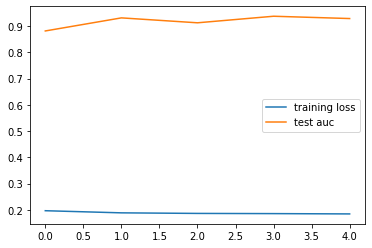

In [57]:
args =  {'input_dim': node_dim, 'hidden_dim': 32, 'output_dim': 16,
         'num_hidden_layers': 1, 'dropout': 0.0, 'metric': 'cosine',
         'epochs': 5,  'lr': 0.001, 'batch_size': 256, # half of actual batch size
         }

class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

args = objectview(args)

# build model + optimizer
model_gat = GAT(args.input_dim, args.hidden_dim, args.output_dim, adj_matrix_src2tar.to(device),
            args.num_hidden_layers, args.dropout).to(device)
print(model_gat)

optimizer = torch.optim.Adam(model_gat.parameters(), lr=args.lr)
criterion = torch.nn.BCEWithLogitsLoss()

# model.eval()
# model(embs_matrix)


from tqdm import trange
import math

# train
metric = args.metric   # fc, l2 are worse then cosine
losses = []
test_aucs = []
best_auc = 0
best_model_gat = []
num_train_pairs = len(train_pos_edges_T[0])
embs_matrix = embs_matrix.to(device)

# 9:28pm starting from epoch 11, train to epoch 20, let see there are an improvement
for epoch in range(1, args.epochs+1):
    total_loss = 0
    model_gat.train()
    
    for i in trange(math.floor(num_train_pairs/args.batch_size), desc="Epoch {}".format(epoch), unit="steps"):
        # list_index = args.batch_size*i:args.batch_size*(i+1)

        source = F.normalize(model_gat(embs_matrix, 'src'), dim=1)
        target = F.normalize(model_gat(embs_matrix, 'tar'), dim=1)

        indices = range(args.batch_size*i, args.batch_size*(i+1))
        pos_u = source[train_pos_edges_T[0][indices]]
        pos_v = target[train_pos_edges_T[1][indices]]
        pred_pos = (pos_u*pos_v).sum(dim=1)

        neg_u = source[train_neg_edges_T[0][indices]]
        neg_v = target[train_neg_edges_T[1][indices]]
        pred_neg = (neg_u*neg_v).sum(dim=1)
        
        optimizer.zero_grad()
        pred = torch.cat((pred_pos, pred_neg), dim=0)
        label = torch.Tensor(args.batch_size*[1]+args.batch_size*[0]).to(device)
        loss = criterion(pred, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() 

    total_loss /= num_train_pairs
    losses.append(total_loss*100)

    if epoch % 1 == 0:
        test_auc = 0
        model_gat.eval()

        with torch.no_grad():
            source = F.normalize(model_gat(embs_matrix, 'src'), dim=1)
            target = F.normalize(model_gat(embs_matrix, 'tar'), dim=1)

            pos_u = source[valid_pos_edges_T[0]]
            pos_v = target[valid_pos_edges_T[1]]
            pred_pos = (pos_u*pos_v).sum(dim=1)

            neg_u = source[valid_neg_edges_T[0]]
            neg_v = target[valid_neg_edges_T[1]]
            pred_neg = (neg_u*neg_v).sum(dim=1)
        
            pred = torch.cat((pred_pos, pred_neg), dim=0).to('cpu')
            test_auc = roc_auc_score(valid_labels, pred)
            test_aucs.append(test_auc)
            print('auc score ', test_auc)

        if test_auc > best_auc:
            best_auc = test_auc
            print('best auc {} achieved at epoch {}'.format(best_auc, epoch))
            # best_model_gat = copy.deepcopy(model_gat)

    else:
        test_aucs.append(test_aucs[-1])

plt.plot(losses, label="training loss")
plt.plot(test_aucs, label="test auc")
plt.legend()
plt.show()


In [ ]:
# prediction
def get_test_scores(test_edges_T):
    model.eval()
    with torch.no_grad():
        source = F.normalize(model(embs_matrix, 'src'), dim=1)
        target = F.normalize(model(embs_matrix, 'tar'), dim=1)

        u = source[test_edges_T[0]]
        v = target[test_edges_T[1]]
        pred = (u*v).sum(dim=1).to('cpu')
    return pred

test_edges = load_test_data(test_file, uid2index)
test_edges_T = convert_str_edges_to_tensor(test_edges)
scores = get_test_scores(test_edges_T)

# check the order of test_edges_T
assert ind2uid[int(test_edges_T[0][0])] ==  'NfU0zDaTMEQ4-X9dbQWd9A'
assert ind2uid[int(test_edges_T[1][20])] ==  'AOcBQ6FZAfeHX6P7JvwRcA'

In [ ]:
df = pd.read_csv('data/test.csv')
df["score"] = scores
os.mkdir('data/gat_0.9434')
df.to_csv('data/gat_0.9434/pred.csv', index=False)

In [ ]:
torch.save(model.state_dict(), 'data/gat_0.9434/best_gat_checkpoint.pth')
print(scores)

# why do we have negative numbers here?? it is supposed to lie b/w 0 and 1?
# no, don't need that: "This is possible because the implementation only requires that the y_true can be sorted according to the y_score."
# https://datascience.stackexchange.com/questions/40940/why-is-sklearn-metrics-roc-auc-score-seemingly-able-to-accept-scores-on-any-sc

tensor([ 0.5684, -0.9792,  0.9836,  ...,  0.9367,  0.7621,  0.9882])


# GNN

We apply Graph Deep Neural Network (GraphSAGE, GAT, ..), expect an improvement. 

We can use [DGL](https://docs.dgl.ai/en/0.7.x/tutorials/blitz/4_link_predict.html), but we prefer PyTorch Geometric (a [sample](https://github.com/Orbifold/pyg-link-prediction/blob/main/Pokec-Pyg-Neo4j.ipynb))

BIG TROUBLE: April 26, Google Colab environment starts with PyTorch has version 1.11.0+cu113, while PyG is not yet up to date

https://datascience.stackexchange.com/questions/56694/how-to-use-graph-neural-network-to-predict-relationships-between-nodes-with-pyto

In [58]:
import torch
print("PyTorch has version {}".format(torch.__version__))

PyTorch has version 1.11.0+cu113


In [ ]:
!pip install torch==1.10.1+cu111 torchvision==0.11.2+cu111 torchaudio==0.10.1 -f https://download.pytorch.org/whl/torch_stable.html
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-geometric
!pip install -q git+https://github.com/snap-stanford/deepsnap.git

## Building GNN model

In [ ]:
import torch
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
                                    OptTensor)

from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax, degree

In [ ]:
class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args, emb=False):
        super(GNNStack, self).__init__()
        conv_model = self.build_conv_model(args.model_type)
        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim, args))
        assert (args.num_layers >= 1), 'Number of layers is not >=1'
        for l in range(args.num_layers-1):
            self.convs.append(conv_model(args.heads * hidden_dim, hidden_dim, args))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(args.heads * hidden_dim, hidden_dim), nn.Dropout(args.dropout), 
            nn.Linear(hidden_dim, output_dim)
        )

        self.dropout = args.dropout
        self.num_layers = args.num_layers

        self.emb = emb

    def build_conv_model(self, model_type):
        if model_type == 'GraphSage':
            return GraphSage
        elif model_type == 'GAT':
            return GAT

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout,training=self.training)

        x = self.post_mp(x)

        if self.emb == True:
            return x

        return F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

In [ ]:
class GraphSage(MessagePassing):
    
    def __init__(self, in_channels, out_channels, normalize = True,
                 bias = False, **kwargs):  
        super(GraphSage, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize

        self.lin_l = nn.Linear(in_channels, out_channels, bias=bias)
        self.lin_r = nn.Linear(in_channels, out_channels, bias=bias)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        self.lin_r.reset_parameters()

    def forward(self, x, edge_index, size = None):
        aggr = self.propagate(edge_index, x=x)
        x = self.lin_l(x) + self.lin_r(aggr)
        
        # x = batch_size * emb_size
        out = F.normalize(x, dim=1)
        return out

    def message(self, x_j):
        return x_j

    def aggregate(self, inputs, index, dim_size = None):
        # The axis along which to index number of nodes.
        node_dim = self.node_dim # = 0 by default
        
        out = torch_scatter.scatter(inputs, index, dim=node_dim, reduce="mean")
        return out


In [ ]:
class GAT(MessagePassing):

    def __init__(self, in_channels, out_channels, args, heads = 2,
                 negative_slope = 0.2, dropout = 0., **kwargs):
        super(GAT, self).__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = args.heads
        self.negative_slope = negative_slope
        self.dropout = dropout

        self.lin_l = nn.Linear(in_channels, out_channels*self.heads)
        self.lin_r = nn.Linear(in_channels, out_channels*self.heads) # can we write code like this? pointer or data passing?

        self.att_l = nn.Parameter(torch.rand(self.heads, out_channels))
        self.att_r = nn.Parameter(torch.rand(self.heads, out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.lin_l.weight)
        nn.init.xavier_uniform_(self.lin_r.weight)
        nn.init.xavier_uniform_(self.att_l)
        nn.init.xavier_uniform_(self.att_r)

    def forward(self, x, edge_index, size = None):
        H, C = self.heads, self.out_channels
        N = x.shape[0]

        central   = self.lin_l(x).reshape((N,H,C))
        neighbors = self.lin_r(x).reshape((N,H,C))
        alpha_l = (central*self.att_l).sum(dim=2)    # N, H
        alpha_r = (neighbors*self.att_r).sum(dim=2)  # N, H

        aggr = self.propagate(edge_index, x=neighbors, alpha = (alpha_l, alpha_r))  # N, H, C
        out = aggr.reshape((N,H*C))

        return out


    def message(self, x_j, alpha_j, alpha_i, index, ptr, size_i):
        alpha = F.leaky_relu(alpha_i+alpha_j, self.negative_slope)      # E, H
        alpha = torch_geometric.utils.softmax(alpha, index)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)  # E, H
        out = alpha.unsqueeze(dim=2)*x_j    # E,H,1 * E,H*C = E,H,C

        return out


    def aggregate(self, inputs, index, dim_size = None):
        out = torch_scatter.scatter(inputs, index, dim=self.node_dim)    
        return out

## Training model

In [ ]:
import time, os

import networkx as nx
import numpy as np
import torch
import torch.optim as optim
from tqdm import trange
import pandas as pd
import copy

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.nn as pyg_nn

import matplotlib.pyplot as plt

Need to retrieve subgraph to reduce the computing redundance https://pytorch-geometric.readthedocs.io/en/latest/modules/utils.html#torch_geometric.utils.subgraph

In [ ]:
def train(dataset, args):
    # load data
    loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=False)

    # build model + optimizer
    model = GNNStack(dataset.num_node_features, args.hidden_dim, args.output_dim, args, embs=True)

    optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)

    # train
    losses = []
    test_accs = []
    best_acc = 0
    best_model = None

    for epoch in trange(args.epochs, desc="Training", unit="Epochs"):
        total_loss = 0
        model.train()
        
        for batch in loader:
            opt.zero_grad()
            pred = model(batch)
            label = batch.y
            pred = pred[batch.train_mask]
            label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        losses.append(total_loss)

        if epoch % 10 == 0:
          test_acc = test(test_loader, model)
          test_accs.append(test_acc)
          if test_acc > best_acc:
            best_acc = test_acc
            best_model = copy.deepcopy(model)
        else:
          test_accs.append(test_accs[-1])
    
    return test_accs, losses, best_model, best_acc, test_loader

def test(loader, test_model, is_validation=False, save_model_preds=False, model_type=None):
    test_model.eval()

    correct = 0
    # Note that Cora is only one graph!
    for data in loader:
        with torch.no_grad():
            # max(dim=1) returns values, indices tuple; only need indices
            pred = test_model(data).max(dim=1)[1]
            label = data.y

        mask = data.val_mask if is_validation else data.test_mask
        # node classification: only evaluate on nodes in test set
        pred = pred[mask]
        label = label[mask]

        if save_model_preds:
          print ("Saving Model Predictions for Model Type", model_type)

          data = {}
          data['pred'] = pred.view(-1).cpu().detach().numpy()
          data['label'] = label.view(-1).cpu().detach().numpy()

          df = pd.DataFrame(data=data)
          # Save locally as csv
          df.to_csv('CORA-Node-' + model_type + '.csv', sep=',', index=False)
            
        correct += pred.eq(label).sum().item()

    total = 0
    for data in loader.dataset:
        total += torch.sum(data.val_mask if is_validation else data.test_mask).item()

    return correct / total
  
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d


In [ ]:
import os
if 'IS_GRADESCOPE_ENV' not in os.environ:
    for args in [
        {'model_type': 'GraphSage',  'num_layers': 4, 'heads': 1, 'hidden_dim': 32, 'dropout': 0.5, 
         'dataset': 'cora', 'epochs': 500, 'batch_size': 32, 
         'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'weight_decay': 5e-3, 'lr': 0.01},
    ]:
        args = objectview(args)
        for model in ['GAT']:
            args.model_type = model

            # Match the dimension.
            if model == 'GAT':
              args.heads = 4
            else:
              args.heads = 1

            if args.dataset == 'cora':
                dataset = Planetoid(root='/tmp/cora', name='Cora')
            else:
                raise NotImplementedError("Unknown dataset") 
            test_accs, losses, best_model, best_acc, test_loader = train(dataset, args) 

            print("Maximum test set accuracy: {0}".format(max(test_accs)))
            print("Minimum loss: {0}".format(min(losses)))

            # Run test for our best model to save the predictions!
            test(test_loader, best_model, is_validation=False, save_model_preds=True, model_type=model)
            print()

            plt.title(dataset.name)
            plt.plot(losses, label="training loss" + " - " + args.model_type)
            plt.plot(test_accs, label="test accuracy" + " - " + args.model_type)
        plt.legend()
        plt.show()


# TODO

add GraphSAGE-like operation to function get_auc_score(model, ...)

build model to train, especially the loss function

calculate distance bw two test nodes


In [ ]:
def visualize(h, color, epoch=None, loss=None, accuracy=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None and accuracy['train'] is not None and accuracy['val'] is not None:
            plt.xlabel((f'Epoch: {epoch}, Loss: {loss.item():.4f} \n'
                       f'Training Accuracy: {accuracy["train"]*100:.2f}% \n'
                       f' Validation Accuracy: {accuracy["val"]*100:.2f}%'),
                       fontsize=16)
    else:
        nx.draw_networkx(h, pos=nx.spring_layout(h, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()

# visualize(G, color=data.y)

In [ ]:
# check if there are nodes in test set not existing in train set
test_nodes = [x[0] for x in test_edges] + [x[1] for x in test_edges]
len(set(test_nodes).difference(set(graph.nodes)))
# there are several. For those, just ouput the prob. as .5

# count how many pairs
print(sum([(1 if '0' in pair else 0) for pair in valid_edges]))


196


In [ ]:
# with those number of unknown nodes, calculate the max roc_auc_score
ood = 196
ground = (40000-20732)*[1]+ 20732*[0]
pred = (40000-20732-ood)*[1]+ 2*ood*[0.5]+ (20732-ood)*[0]

roc_auc_score(ground, pred)

0.9999519155880452

In [ ]:
first_20_nodes = list(graph.nodes)[:20]

for node in first_20_nodes:
    print(np.average(
        list(nx.single_source_shortest_path_length(graph, node).values())
    ))

# avg shortest path length is ~ 4
# may set the walk_length and smt accordingly

## cannot get the diameter/radius, since the graph is not connected
# graph_undir = graph.to_undirected(reciprocal=False, as_view=True)
# nx.algorithms.distance_measures.radius(graph_undir)

4.102693832900314
3.1329139887870916
3.4593190209216464
3.848352249418843
2.848625734992479
3.616573225762341
3.116504854368932
3.1690140845070425
3.3715301517844933
3.5616026254615067
2.941474087241898
3.0531929440722
2.6930124435936005
4.059756597839464
3.0600300834131
3.9295774647887325
2.9298509503623684
3.9288937508546424
2.9291672364282784
3.1692875700806784


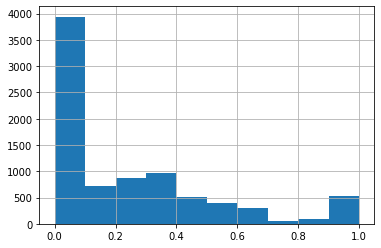

In [ ]:
# graph_undir = graph.to_undirected(reciprocal=False, as_view=True)

clustering = nx.clustering(graph_undir)
pd.Series(clustering).hist(bins=20)
